In [1]:
#Gluonts Package
import gluonts

import scipy as sp
import pandas as pd
import numpy as np
import mxnet as mx
import seaborn as sns
import matplotlib.pyplot as plt
import os

from matplotlib import cm
from typing import Dict, Optional, Tuple, List

from gluonts.model.common import Tensor
from gluonts.core.component import validated
from gluonts.distribution import Distribution, DistributionOutput
from gluonts.distribution.distribution import _sample_multiple, getF, softplus
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.trainer import Trainer
from gluonts.model.canonical._estimator import MLPForecasterEstimator

#S3 Data Package
from aws_poirot_model_benchmark.anomaly_dataset import AnomalyDataset

#SPOT & DSPOT Package
from scipy.optimize import minimize
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

plt.rcParams['figure.figsize'] = (12.8, 9.6) 

# colors for plot
deep_saffron = '#FF9933'
air_force_blue = '#5D8AA8'

In [2]:
data_list = AnomalyDataset.from_s3("s3://poirot-ad-datasets/order-rate/US/data.json")
d = data_list[0]
d

AnomalyDataset object None with 1347422 data points. 

In [3]:
d[:15000].to_s3("s3://poirot-ad-datasets/order-rate/toy/US/data.json")

In [4]:
np.array(d.ts).mean()

7974.844943158119

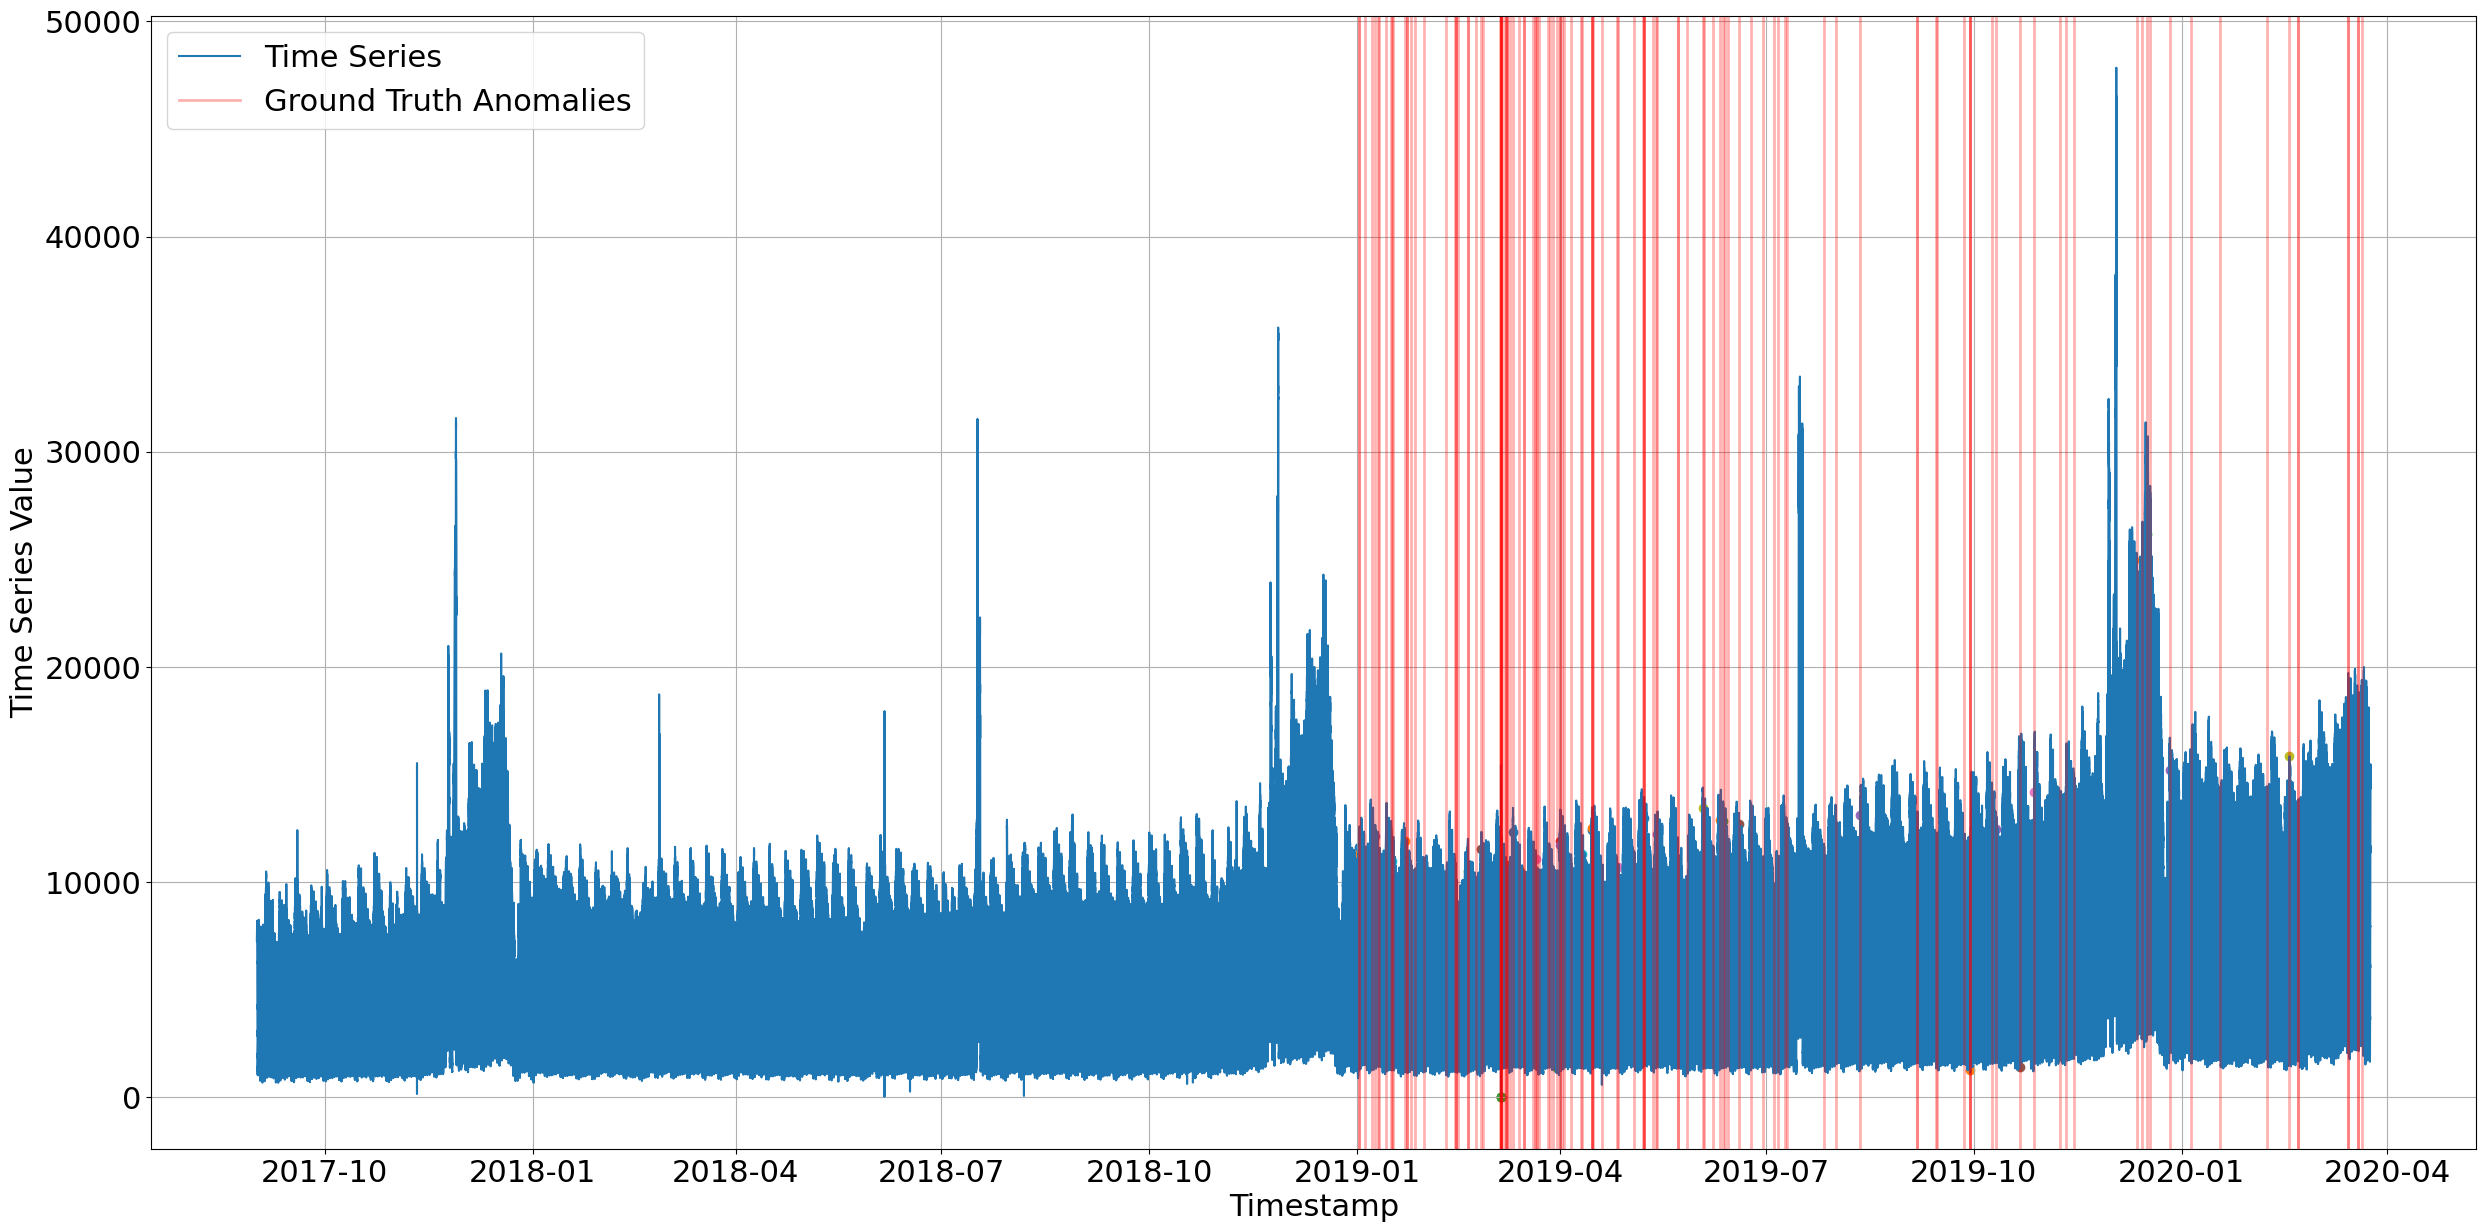

In [5]:
d.plot()

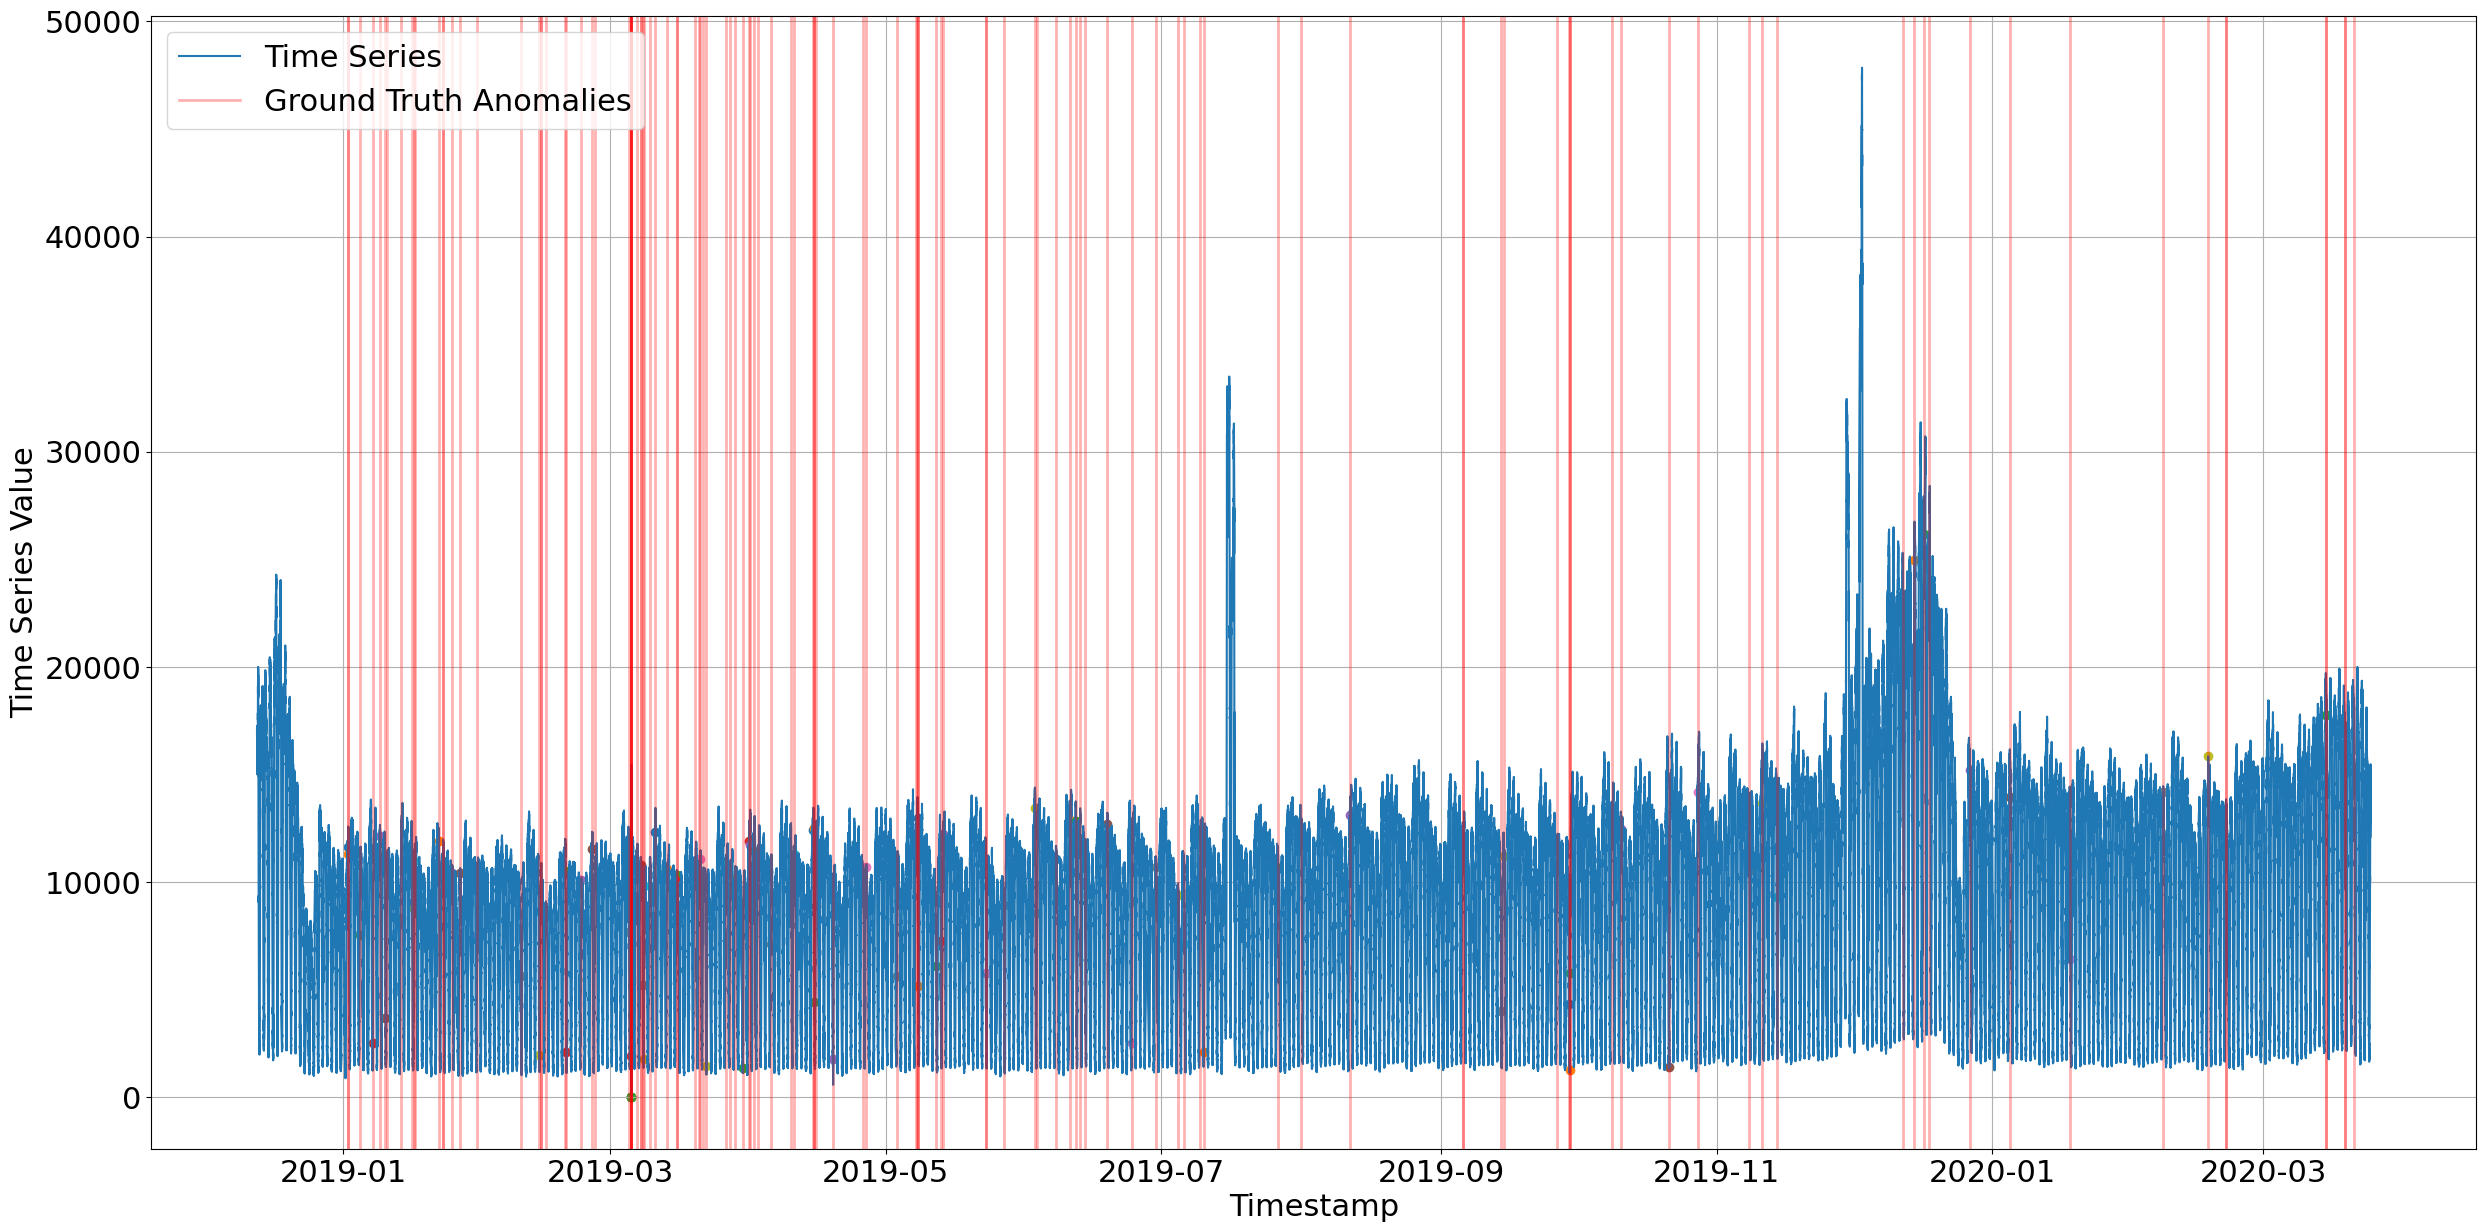

In [6]:
d[len(d)//2:].plot()

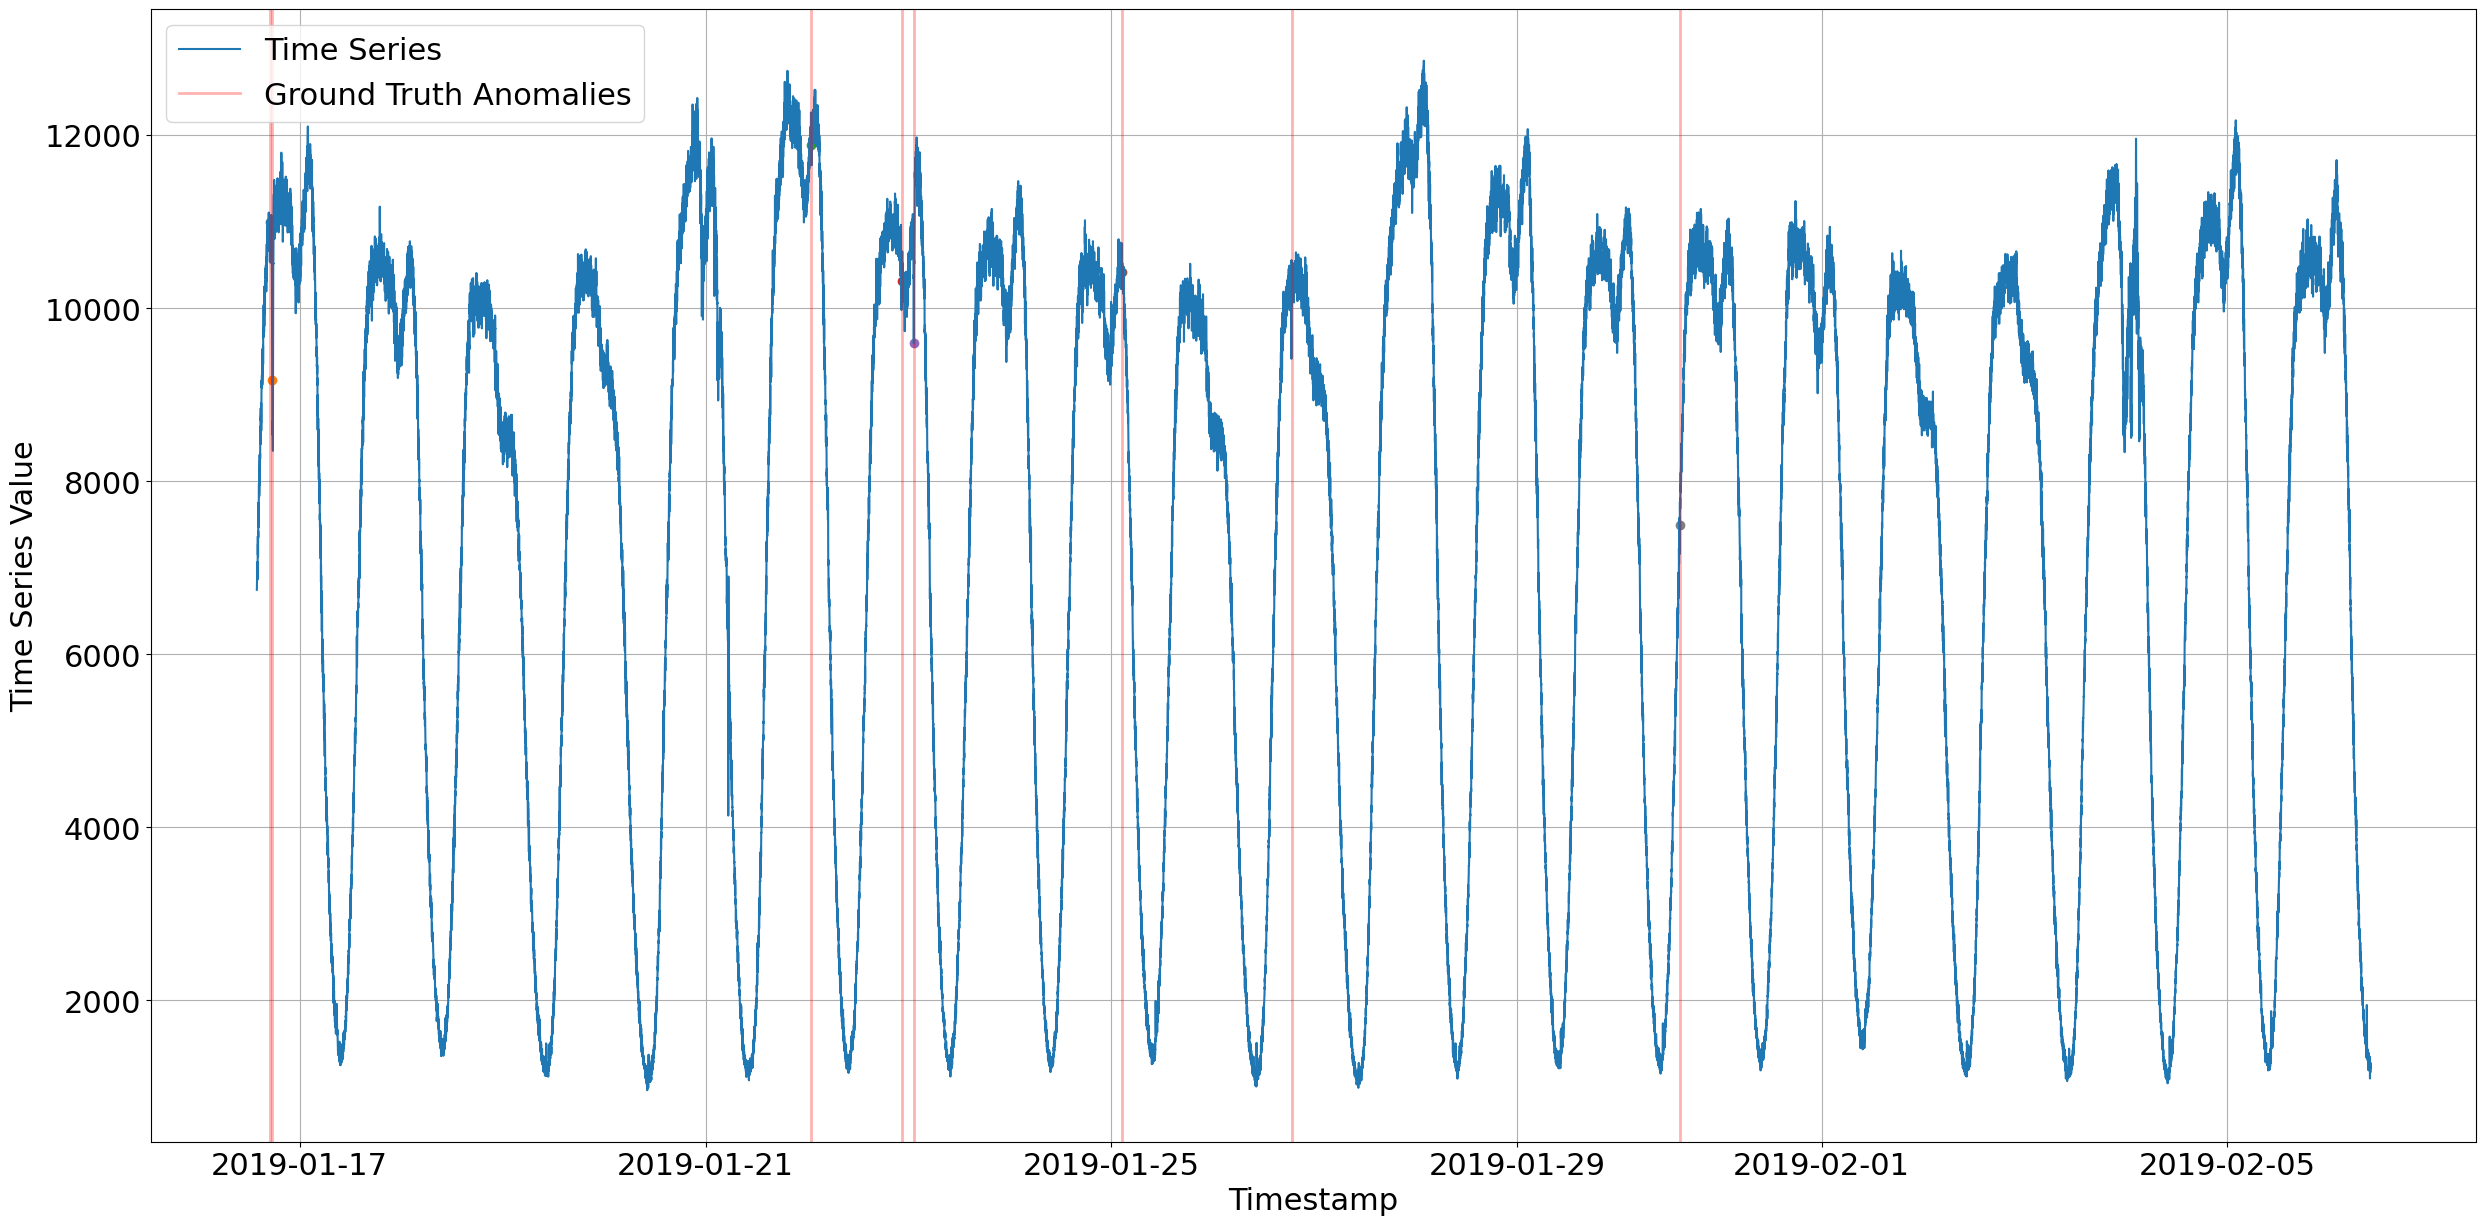

In [7]:
d[len(d)//2+50000:len(d)//2+80000].plot()

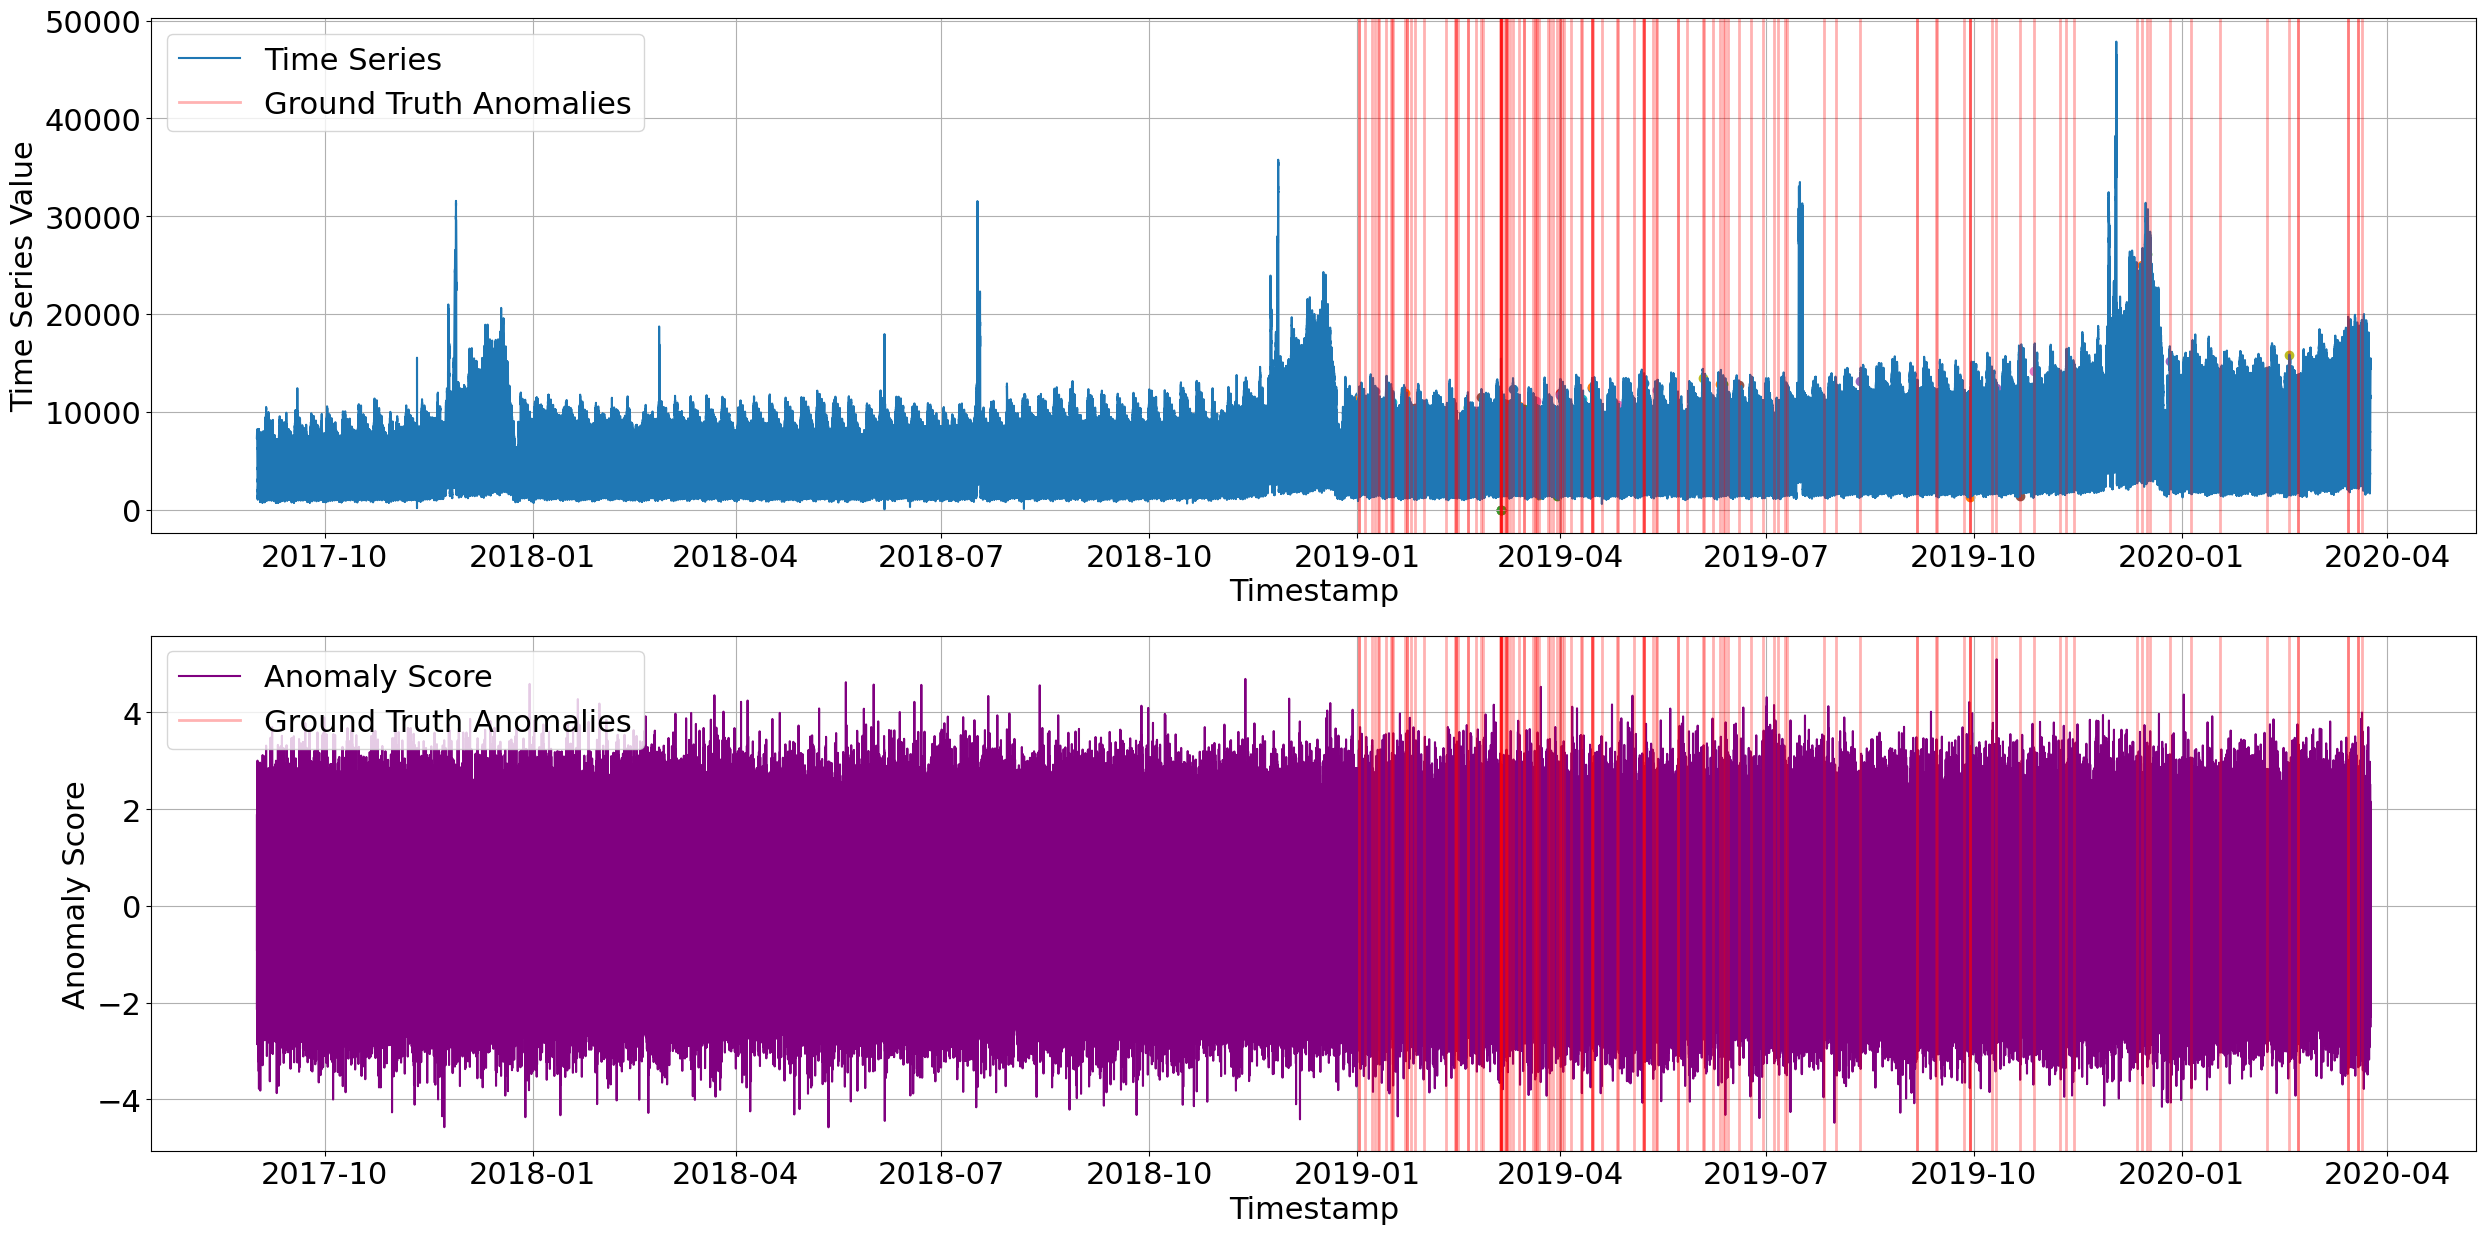

In [8]:
d.anomaly_score = np.random.normal(size=len(d.ts))
d.plot()

# SimpleFeedForward Forecasting Model in GluonTS

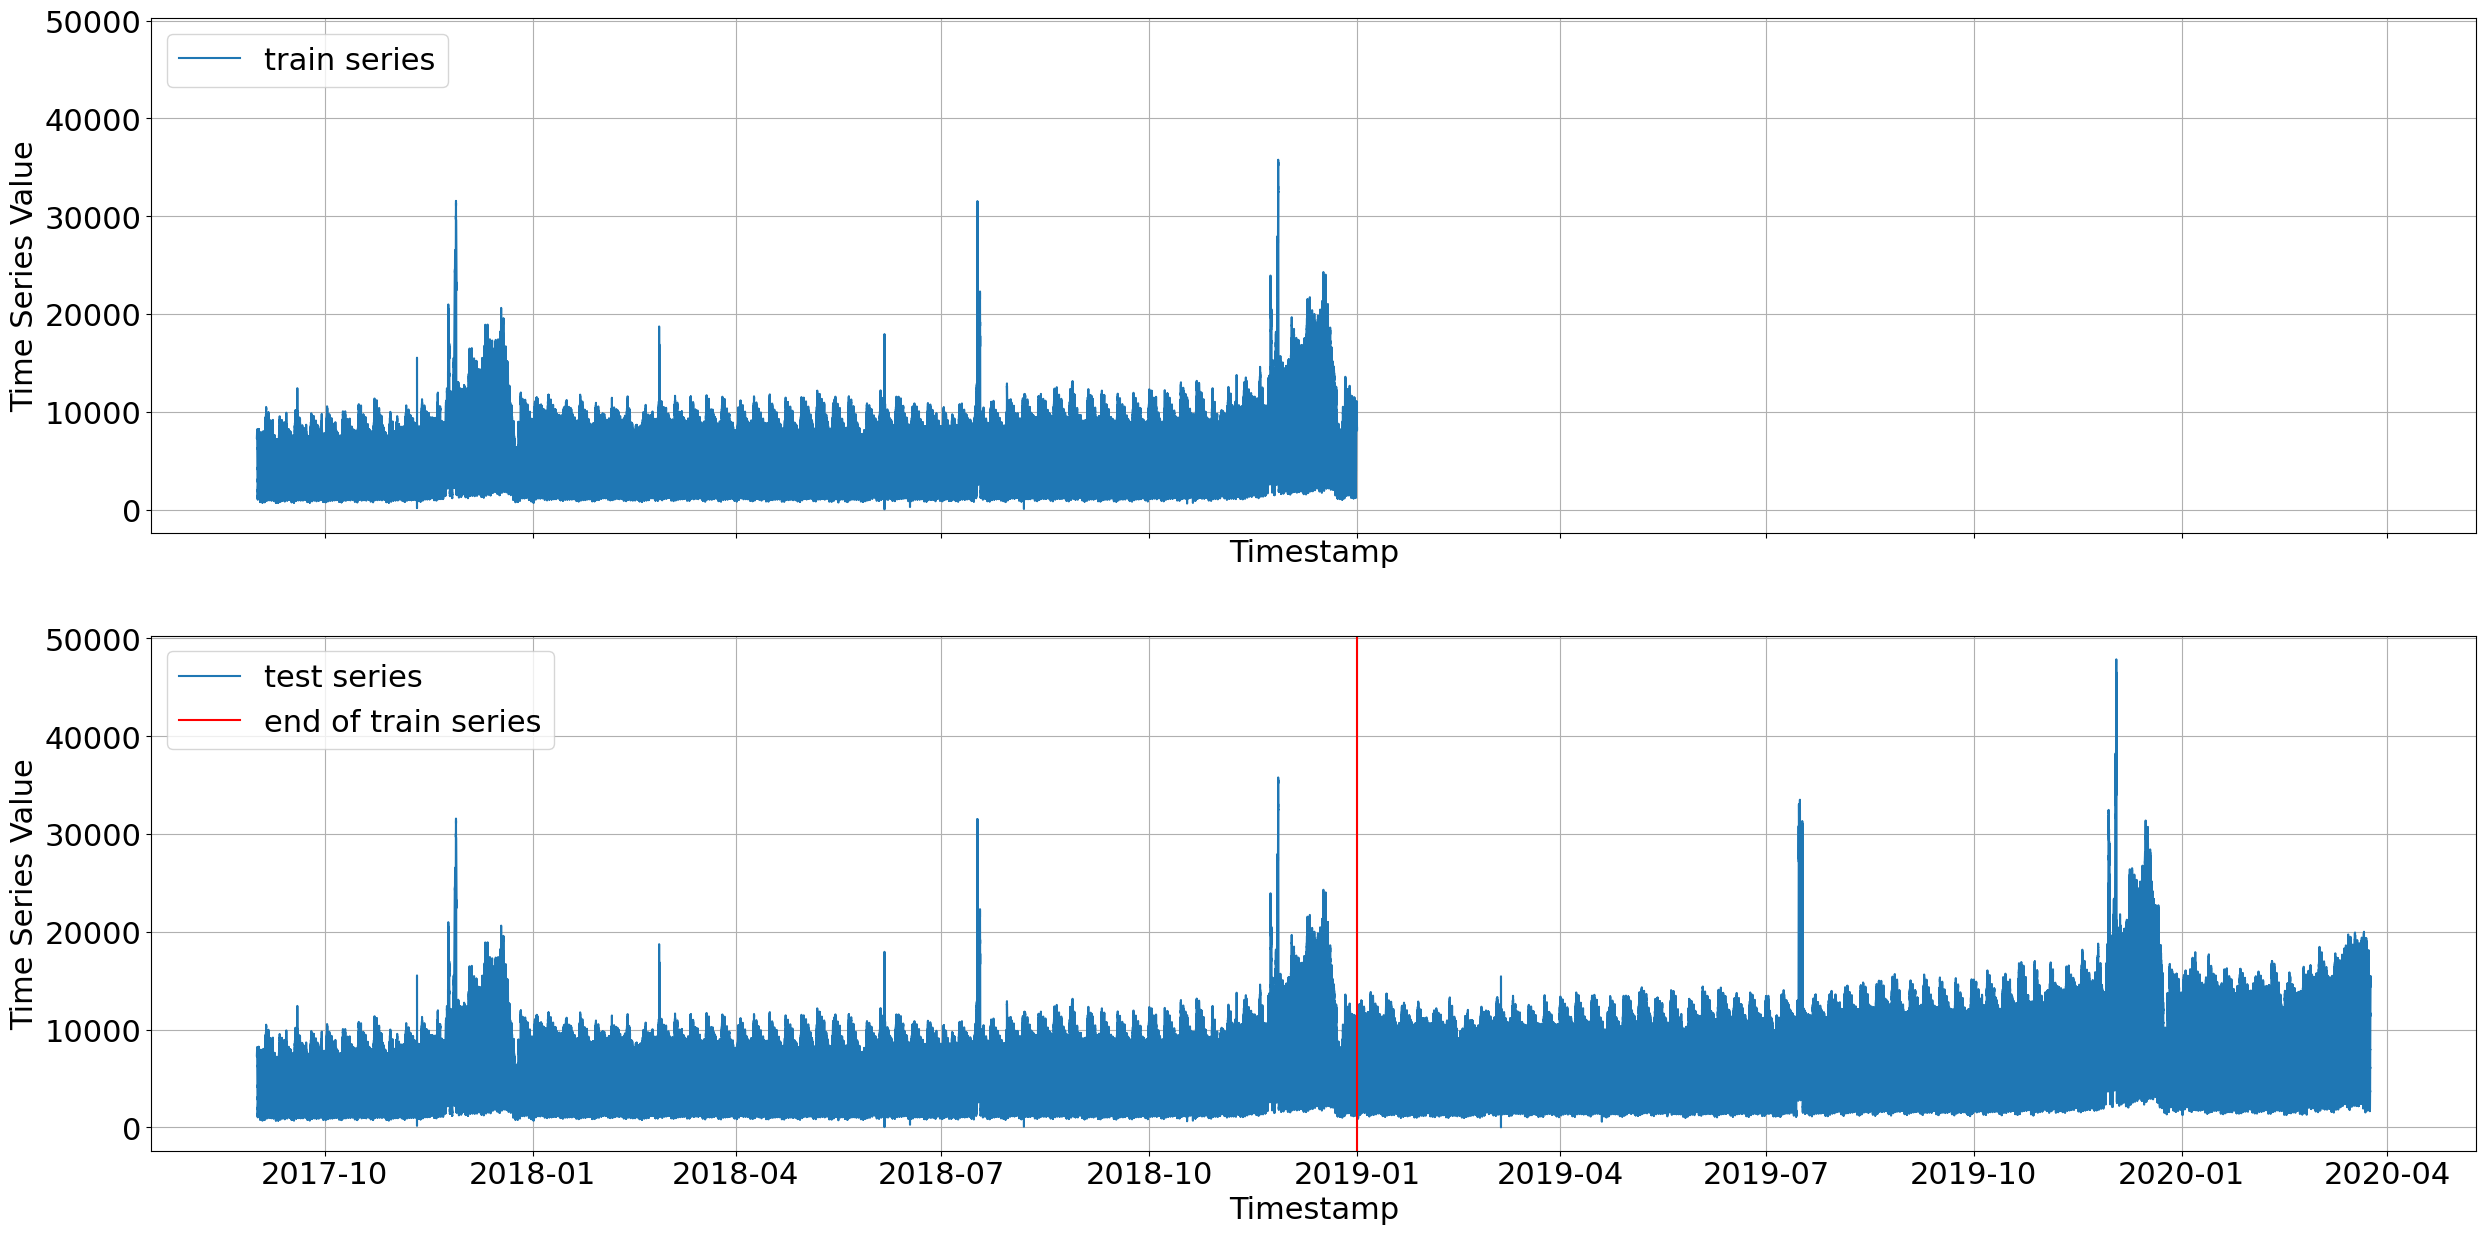

In [9]:
from mxnet import gluon
from gluonts.distribution import Gaussian, GaussianOutput


plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.size'] = 22

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].plot(d.timestamps[:701279], d.ts[:701279])
ax[0].legend(["train series"], loc="upper left")
ax[0].set_ylabel("Time Series Value")
ax[0].set_xlabel("Timestamp")
ax[0].grid(which="both")

ax[1].plot(d.timestamps, d.ts)
ax[1].axvline(d.timestamps[701279], color='r') # end of train dataset
ax[1].legend(["test series", "end of train series"], loc="upper left")
ax[1].set_ylabel("Time Series Value")
ax[1].set_xlabel("Timestamp")
ax[1].grid(which="both")


plt.show()

In [10]:
from gluonts.dataset.common import ListDataset

def mk_ds(df):
    havel_dict_data = df.to_havel_dict()
    feat_dynamic_cat = np.vstack([df.timestamps.hour.values, 
                                 df.timestamps.dayofweek.values, df.timestamps.month.values])
    
    target = havel_dict_data["target"]
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': pd.to_datetime(havel_dict_data["start"]),
        'observed_values': observed,          
        }],
        freq='1min'
    )
    return ds

train_ds = mk_ds(d[:701279])

# SimpleFeedForward Model on the Extreme Values

In [11]:
class PeakOverThresholdGeneralizedPareto(Distribution):
    r"""
    The Generalized Pareto is a continuous distribution defined on the real line.
    This distribution is often used to model the tails of other distributions.


    Parameters
    ----------
      scale: The scale of the distribution. GeneralizedPareto is a
        location-scale distribution, so doubling the `scale` doubles a sample
        and halves the density. Strictly positive floating point `Tensor`. Must
        broadcast with `concentration`.
        
      concentration: The shape parameter of the distribution,
      mapped to `concentration > 0` for heavy tails.
    F
    """
    
    is_reparameterizable = False

    @validated()
    def __init__(self, scale: Tensor, concentration: Tensor, F=None) -> None:
        self.scale = scale
        self.concentration = concentration
        self.F = F if F else getF(concentration)

    @property
    def batch_shape(self) -> Tuple:
        return self.concentration.shape

    @property
    def event_shape(self) -> Tuple:
        return ()

    @property
    def event_dim(self) -> int:
        return 0

    def log_prob(self, x: Tensor) -> Tensor:
        F = self.F
        z = x / self.scale        

        ll = (- F.log(self.scale) 
              - ((self.concentration + 1) / self.concentration) 
              * F.log1p(self.concentration * z))
        
        return ll

    @property
    def mean(self) -> Tensor:
        # Mean is only defined for concentration < 1. How to handle that?
        mu = self.scale / (1 - self.concentration)
        return mu
    

    @property
    def stddev(self) -> Tensor:
        # Variance is only defined for concentration < 1/2. How?
        F = self.F
        return self.scale / ((1 - self.concentration)* self.F.sqrt(1 - 2 * self.concentration))
        
        
    def cdf(self, x: Tensor) -> Tensor:
        F = self.F
        z = x / self.scale
        u = 1 - F.power(1 + self.concentration * z, - 1 / self.concentration )
        return u
        
    
    def base_distribution_quantile(self, level: Tensor, threshold: Tensor, peak_ratio: Tensor, transforms, below=False) -> Tensor:
        """
        Computes the tail quantile of the base distribution using the fitted extreme value distribution. 
        """
        
        F = self.F
        sgn = -1 if below else 1
        
        # Base GPD quantile
        base_q = (self.scale/self.concentration) * (F.power( level / peak_ratio, -self.concentration) - 1)
        
        # Reversing the transforms
        for t in transforms:
            base_q = t.f(base_q)
        
        # Applying over/below threshold
        q = threshold + sgn * base_q
        
        return q
        

    def sample(
        self, num_samples: Optional[int] = None, dtype=np.float32
    ) -> Tensor:
        def s(scale: Tensor, concentration: Tensor) -> Tensor:
            F = self.F
            ones = concentration.ones_like()

            smpl = scale * (F.power(
                F.random.uniform(0 * ones, 1 * ones, dtype=dtype),
                -concentration) - 1) / concentration
        
            return smpl
            
        return _sample_multiple(s, scale=self.scale, concentration=self.concentration, num_samples=num_samples)

    @property
    def args(self) -> List:
        return [self.scale, self.concentration]

    
class PeakOverThresholdGeneralizedParetoOutput(DistributionOutput):
    args_dim: Dict[str, int] = {"scale": 1, "concentration": 1}
    distr_cls: type = PeakOverThresholdGeneralizedPareto

    @classmethod
    def domain_map(cls, F, scale, concentration):
        scale = 1e-4 + softplus(F, scale)  
        concentration = 1e-4 + softplus(F, concentration)
        return scale.squeeze(axis=-1), concentration.squeeze(axis=-1)

    @property
    def event_shape(self) -> Tuple:
        return ()

In [12]:
from typing import List, Tuple

# Third-party imports
import mxnet as mx

# First-party imports
from gluonts.block.scaler import MeanScaler, NOPScaler
from gluonts.core.component import validated
from gluonts.distribution import Distribution, DistributionOutput
from gluonts.model.common import Tensor


class FeedForwardNetworkBase(mx.gluon.HybridBlock):
    """
    Abstract base class to implement feed-forward networks for probabilistic
    time series prediction.

    This class does not implement hybrid_forward: this is delegated
    to the two subclasses SimpleFeedForwardTrainingNetwork and
    SimpleFeedForwardPredictionNetwork, that define respectively how to
    compute the loss and how to generate predictions.

    Parameters
    ----------
    num_hidden_dimensions
        Number of hidden nodes in each layer.
    prediction_length
        Number of time units to predict.
    context_length
        Number of time units that condition the predictions.
    batch_normalization
        Whether to use batch normalization.
    mean_scaling
        Scale the network input by the data mean and the network output by
        its inverse.
    distr_output
        Distribution to fit.
    kwargs
    """

    # Needs the validated decorator so that arguments types are checked and
    # the block can be serialized.
    @validated()
    def __init__(
        self,
        num_hidden_dimensions: List[int],
        prediction_length: int,
        context_length: int,
        batch_normalization: bool,
        mean_scaling: bool,
        distr_output: DistributionOutput,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        self.num_hidden_dimensions = num_hidden_dimensions
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.batch_normalization = batch_normalization
        self.mean_scaling = mean_scaling
        self.distr_output = distr_output

        with self.name_scope():
            self.distr_args_proj = self.distr_output.get_args_proj()
            self.mlp = mx.gluon.nn.HybridSequential()
            dims = self.num_hidden_dimensions
            for layer_no, units in enumerate(dims[:-1]):
                self.mlp.add(mx.gluon.nn.Dense(units=units, activation="relu"))
                if self.batch_normalization:
                    self.mlp.add(mx.gluon.nn.BatchNorm())
            self.mlp.add(mx.gluon.nn.Dense(units=prediction_length * dims[-1]))
            self.mlp.add(
                mx.gluon.nn.HybridLambda(
                    lambda F, o: F.reshape(
                        o, (-1, prediction_length, dims[-1])
                    )
                )
            )
            self.scaler = MeanScaler() if mean_scaling else NOPScaler()

    def get_distr_args_loc_scale(
        self, F, past_target: Tensor
    ) -> Tuple[Tuple[Tensor, ...], Tensor, Tensor]:
        """
        Given past target values, applies the feed-forward network and
        maps the output to a probability distribution for future observations.

        Parameters
        ----------
        F
        past_target
            Tensor containing past target observations.
            Shape: (batch_size, context_length, target_dim).

        Returns
        -------
        Distribution
            The predicted probability distribution for future observations.
        """

        # (batch_size, seq_len, target_dim) and (batch_size, seq_len, target_dim)
        scaled_target, target_scale = self.scaler(
            past_target,
            F.ones_like(past_target),  # TODO: pass the actual observed here
        )
        mlp_outputs = self.mlp(scaled_target)
        distr_args = self.distr_args_proj(mlp_outputs)

        return distr_args, F.zeros_like(target_scale), target_scale


class FeedForwardTrainingNetwork(FeedForwardNetworkBase):#inside train_model()
    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self, F, past_target: Tensor, future_target: Tensor
    ) -> Tensor:
        distr_args, loc, scale = self.get_distr_args_loc_scale(F, past_target)

        distr = self.distr_output.distribution(
            distr_args, scale=scale.expand_dims(axis=1)
        )

        # (batch_size, prediction_length, target_dim)
        loss = distr.loss(future_target)

        # (batch_size, )
        return loss.mean(axis=1)


class FeedForwardPredictionNetwork(FeedForwardNetworkBase):#inside train_model() self.create_predictor()
    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self, F, past_target: Tensor
    ) -> Tuple[Tuple[Tensor, ...], Tensor, Tensor]:
        distr_args, loc, scale = self.get_distr_args_loc_scale(F, past_target)
        return distr_args, scale



In [13]:
from typing import List, Optional

# Third-party imports
from mxnet.gluon import HybridBlock

# First-party imports
from gluonts.core.component import validated
from gluonts.dataset.field_names import FieldName
from gluonts.distribution import DistributionOutput, GaussianOutput
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.model.forecast_generator import DistributionForecastGenerator
from gluonts.trainer import Trainer
from gluonts.transform import (
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    Transformation,
    AsNumpyArray,
)
from gluonts.support.util import copy_parameters


class FeedForwardEstimator(GluonEstimator):#Return gluonts.model.estimator.GluonEstimator train_model 


    """
    FeedForwardEstimator

    Parameters
    ----------
    freq
        Time time granularity of the data
    prediction_length
        Length of the prediction horizon
    trainer
        Trainer object to be used (default: Trainer())
    num_hidden_dimensions
        Number of hidden nodes in each layer (default: [40, 40])
    context_length
        Number of time units that condition the predictions
        (default: None, in which case context_length = prediction_length)
    distr_output
        Distribution to fit (default: GaussianOutput())
    batch_normalization
        Whether to use batch normalization (default: False)
    mean_scaling
        Scale the network input by the data mean and the network output by
        its inverse (default: True)
    num_parallel_samples
        Number of evaluation samples per time series to increase parallelism during inference.
        This is a model optimization that does not affect the accuracy (default: 100)
    """

    # The validated() decorator makes sure that parameters are checked by
    # Pydantic and allows to serialize/print models. Note that all parameters
    # have defaults except for `freq` and `prediction_length`. which is
    # recommended in GluonTS to allow to compare models easily.
    @validated()
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        trainer: Trainer = Trainer(),
        num_hidden_dimensions: Optional[List[int]] = None,
        context_length: Optional[int] = None,
        distr_output: DistributionOutput = GaussianOutput(),
        batch_normalization: bool = False,
        mean_scaling: bool = True,
        num_parallel_samples: int = 100,
    ) -> None:
        """
        Defines an estimator. All parameters should be serializable.
        """
        super().__init__(trainer=trainer)

        assert (
            prediction_length > 0
        ), "The value of `prediction_length` should be > 0"
        assert (
            context_length is None or context_length > 0
        ), "The value of `context_length` should be > 0"
        assert num_hidden_dimensions is None or (
            [d > 0 for d in num_hidden_dimensions]
        ), "Elements of `num_hidden_dimensions` should be > 0"
        assert (
            num_parallel_samples > 0
        ), "The value of `num_parallel_samples` should be > 0"

        self.num_hidden_dimensions = (
            num_hidden_dimensions
            if num_hidden_dimensions is not None
            else list([40, 40])
        )
        self.prediction_length = prediction_length
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.freq = freq
        self.distr_output = distr_output
        self.batch_normalization = batch_normalization
        self.mean_scaling = mean_scaling
        self.num_parallel_samples = num_parallel_samples

    # here we do only a simple operation to convert the input data to a form
    # that can be digested by our model by only splitting the target in two, a
    # conditioning part and a to-predict part, for each training example.
    # fFr a more complex transformation example, see the `gluonts.model.deepar`
    # transformation that includes time features, age feature, observed values
    # indicator, ...
    def create_transformation(self) -> Transformation:
        return Chain(
            [
                AsNumpyArray(field=FieldName.TARGET, expected_ndim=1),
                InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                    time_series_fields=[FieldName.FEAT_DYNAMIC_REAL, FieldName.FEAT_DYNAMIC_CAT]
                )
            ]
        )

    # defines the network, we get to see one batch to initialize it.
    # the network should return at least one tensor that is used as a loss to minimize in the training loop.
    # several tensors can be returned for instance for analysis, see DeepARTrainingNetwork for an example.
    def create_training_network(self) -> HybridBlock:
        return FeedForwardTrainingNetwork(
            num_hidden_dimensions=self.num_hidden_dimensions,
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            batch_normalization=self.batch_normalization,
            mean_scaling=self.mean_scaling,
        )

    # we now define how the prediction happens given that we are provided a
    # training network.
    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = FeedForwardPredictionNetwork(
            num_hidden_dimensions=self.num_hidden_dimensions,
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            batch_normalization=self.batch_normalization,
            mean_scaling=self.mean_scaling,
        )

        copy_parameters(net_source=trained_network, net_dest=prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            forecast_generator=DistributionForecastGenerator(
                self.distr_output
            ),
            ctx=self.trainer.ctx,
        )



# Gaussian, prediction_length=10, context_length=60

In [14]:
from gluonts.distribution import GaussianOutput

estimator_10 = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=10,
    context_length=60,
    freq='1min',
    trainer = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        ),
    distr_output = GaussianOutput()
)

predictor_10 = estimator_10.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [05:00<00:00,  3.01s/it, epoch=50/50, avg_epoch_loss=7.03]


Running evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

0    0.0
Name: Coverage[0.02], dtype: float64


Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]


0    0.0
Name: Coverage[0.02], dtype: float64


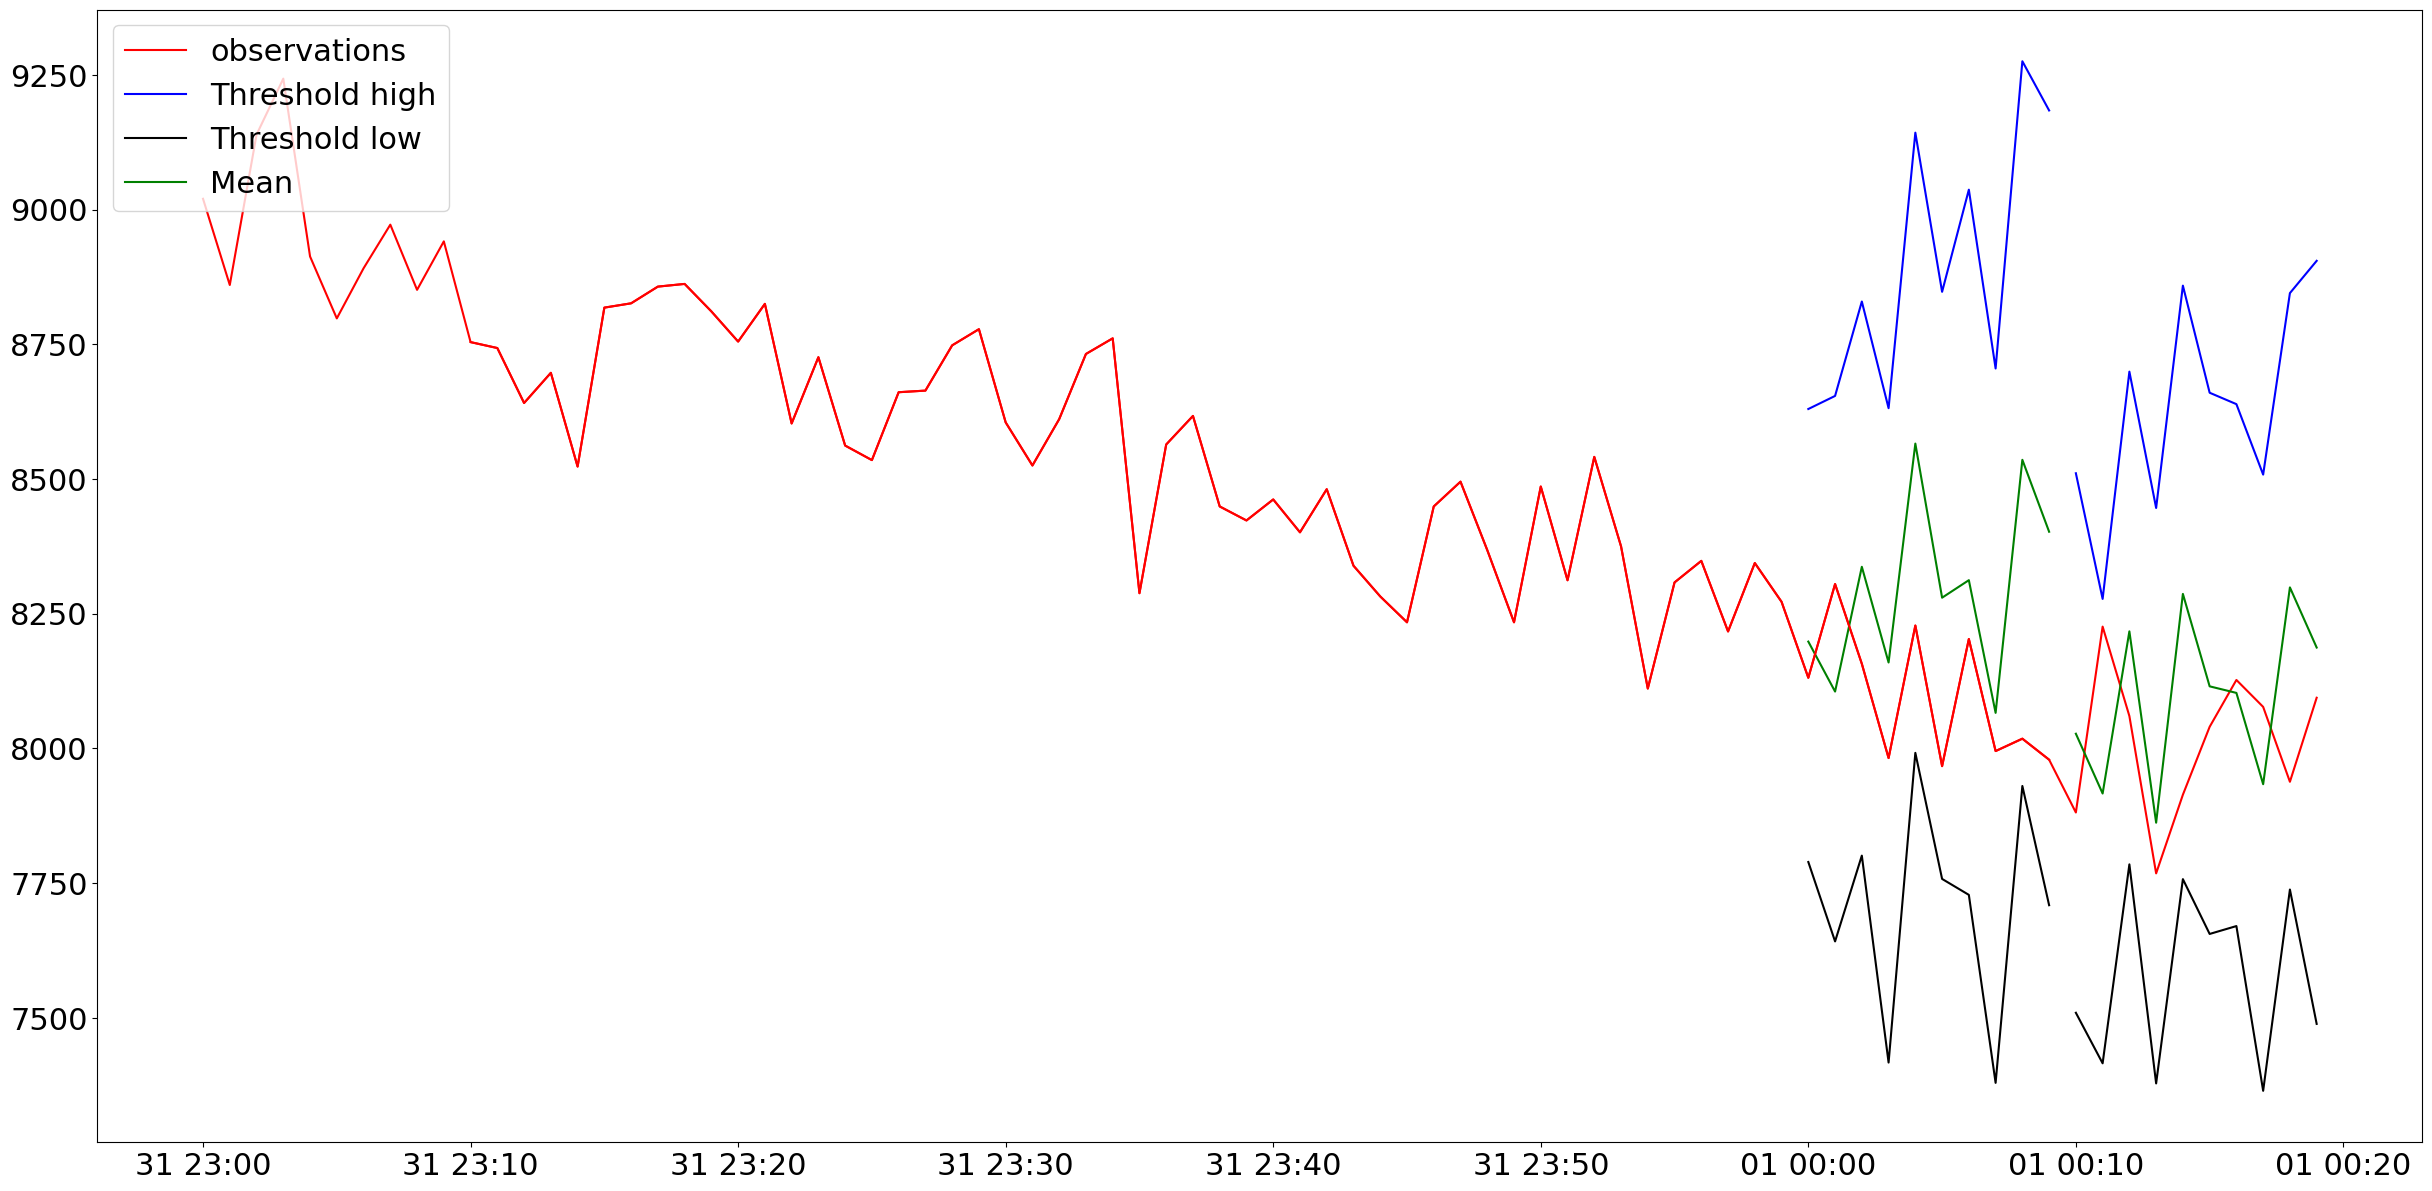

In [60]:
from gluonts.evaluation import Evaluator

fig_10, ax_10 = plt.subplots(1, 1)

def plot_prob_forecasts_10(recur, ts_entry, forecast_entry):
    plot_length = 60+10
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax_10.plot(ts_entry, color='r', label='observations')
#     print(ts_entry)
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

peakover_10 = []
peakbelow_10 = []
peakover_point_10 = []
peakbelow_point_10 = []
threshold_over_10 = []
threshold_below_10 = []
mean_10 = []
score_10 = []

period_10 = 2
    
for recur_10 in range(period_10):
    test_ds_10 = mk_ds(d[701280-60*1+10*recur_10:701280-60*1+10*recur_10+60*1+10]) #End: 1347422

    forecast_it_10, ts_it_10 = make_evaluation_predictions(
        dataset=test_ds_10,  # test dataset
        predictor=predictor_10,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts_10 = list(forecast_it_10)
    tss_10 = list(ts_it_10)

    # first entry of the time series list
    ts_entry_10 = tss_10[0]

    # first entry of test_ds
    #test_ds_entry_10 = next(iter(test_ds_10))

    # first entry of the forecast list
    forecast_entry_10 = forecasts_10[0]
    
    #score
    evaluator = Evaluator(quantiles=[0.02, 0.98])
    agg_metrics, item_metrics = evaluator(iter(tss_10), iter(forecasts_10), num_series=len(test_ds_10))
    print(item_metrics['Coverage[0.02]'])
    #print(ts_entry_10[60:])
    #print(forecast_entry_10.quantile(0.02))
    for j_10 in range(10):
        score_10.append(abs((forecast_entry_10.quantile(0.02))[j_10] - ts_entry_10[0][60+j_10])/ts_entry_10[0][60+j_10])
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over_10.extend(forecast_entry_10.quantile(0.98))
    threshold_below_10.extend(forecast_entry_10.quantile(0.02))
    mean_10.extend(forecast_entry_10.mean)
#     print(ts_entry_10)
#     print(len(ts_entry_10))
    for i_10 in range(len(forecast_entry_10.quantile(0.98))):
        threshold_high_10 = (forecast_entry_10.quantile(0.98))[i_10]
        threshold_low_10 = (forecast_entry_10.quantile(0.02))[i_10]
        peakover_10.append(ts_entry_10[0][60+i_10] - threshold_high_10 if ts_entry_10[0][60+i_10] - threshold_high_10 >= 0 else np.nan)
        peakbelow_10.append(threshold_low_10 - ts_entry_10[0][60+i_10] if ts_entry_10[0][60+i_10] - threshold_low_10 <= 0 else np.nan)
        peakover_point_10.append(ts_entry_10[0][60+i_10] if ts_entry_10[0][60+i_10] - threshold_high_10 >= 0 else np.nan)
        peakbelow_point_10.append(ts_entry_10[0][60+i_10] if ts_entry_10[0][60+i_10] - threshold_low_10 <= 0 else np.nan)

    plot_prob_forecasts_10(recur_10, ts_entry_10, forecast_entry_10)

#print(score_10)
plt.show()

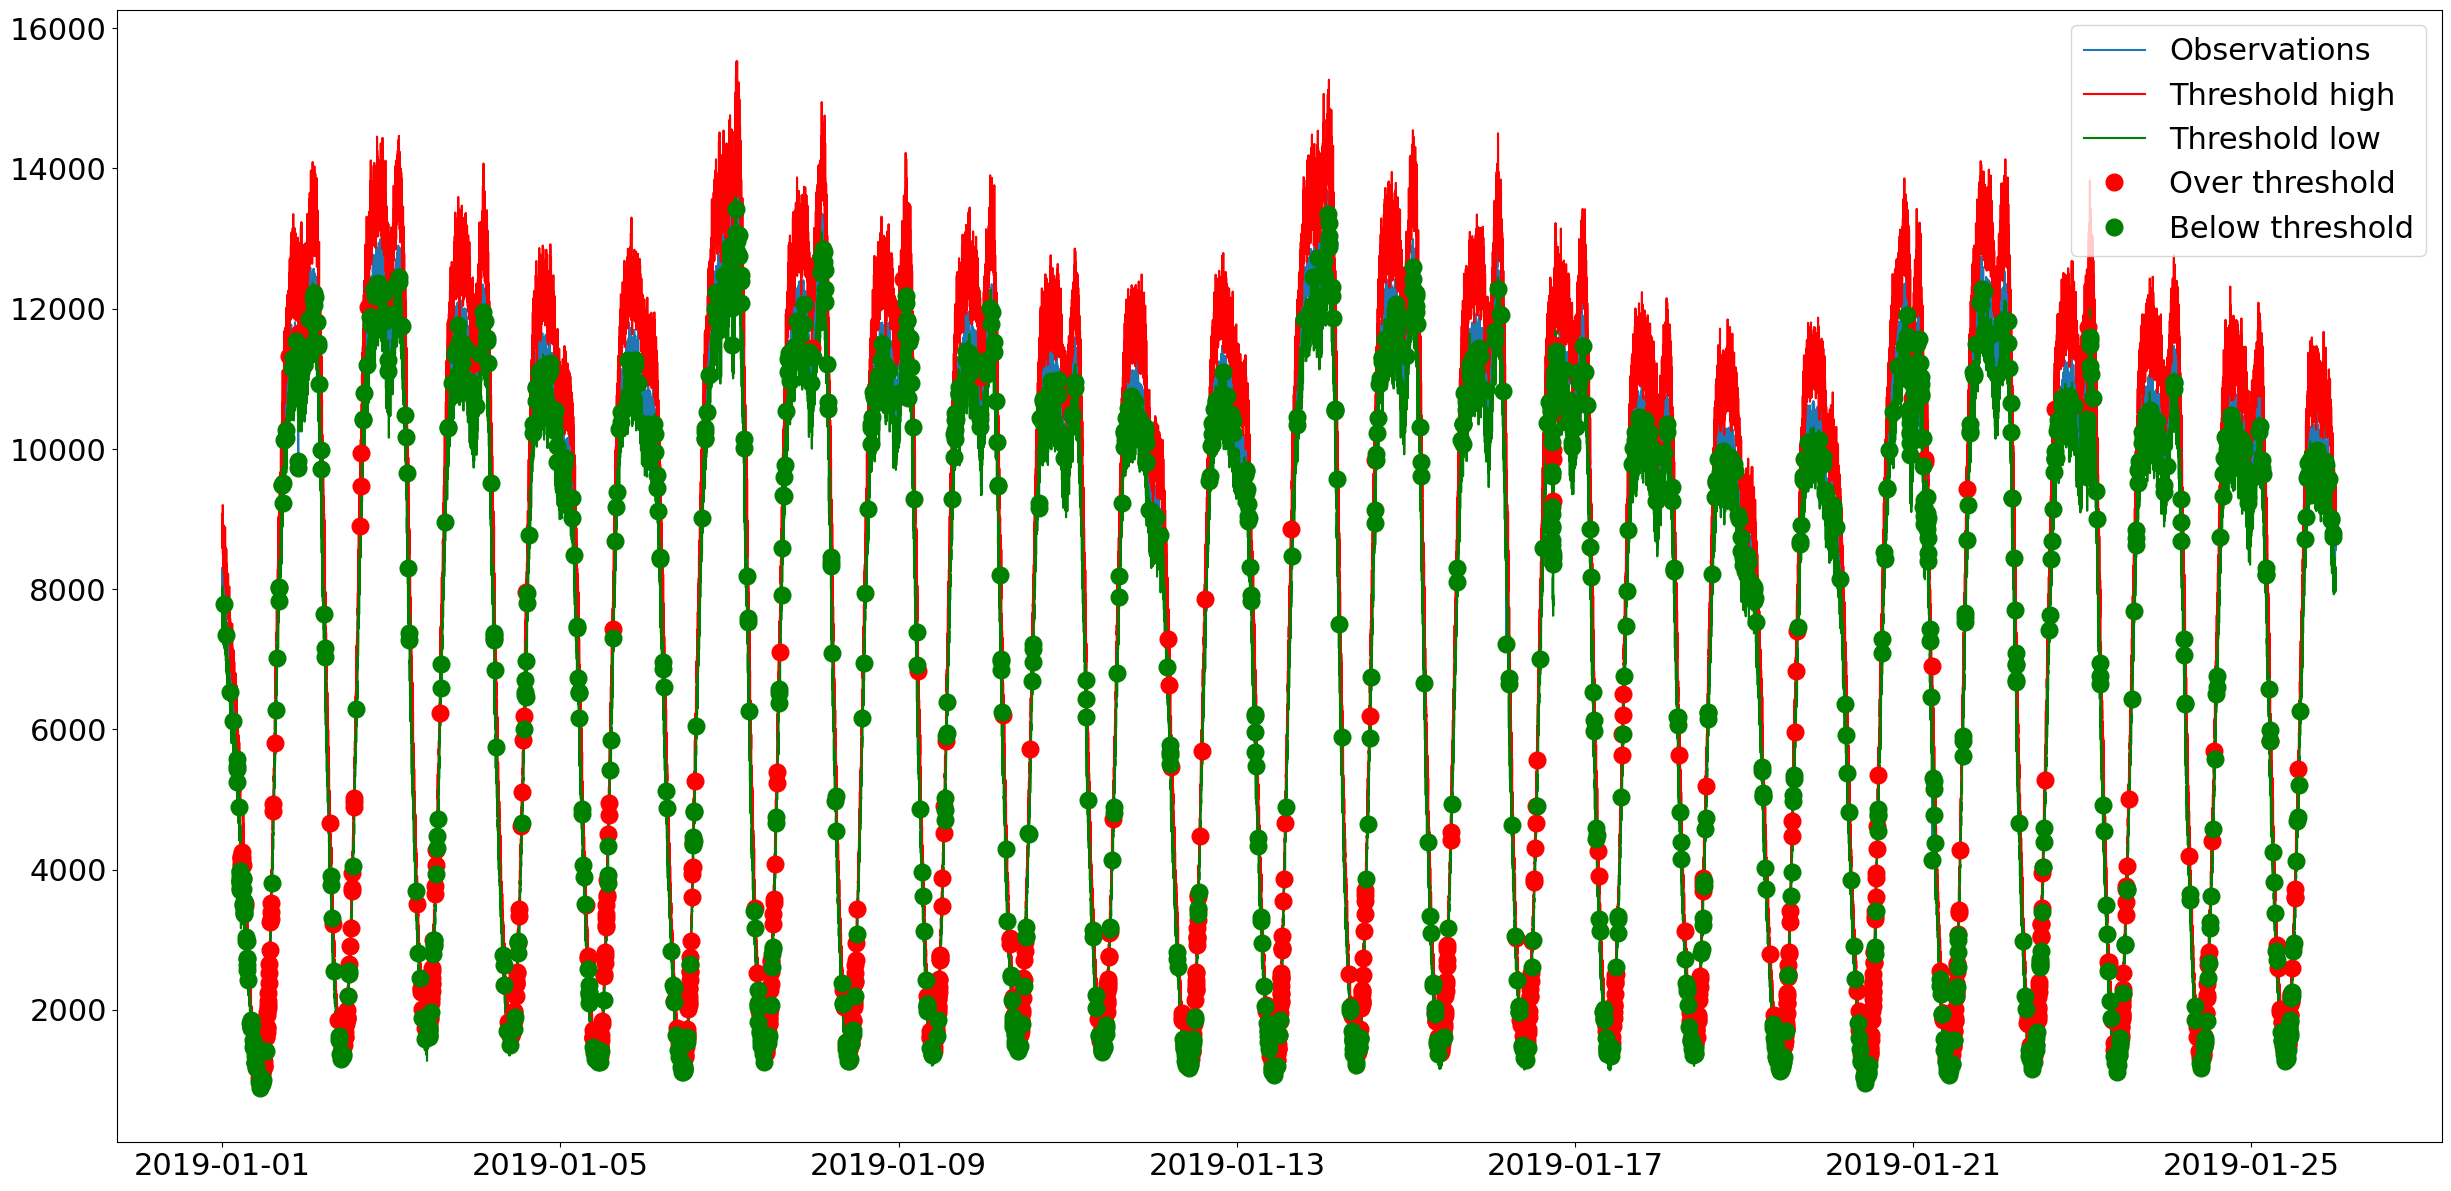

In [16]:
def plot_peaks_10():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)
    
    ax.plot(d.timestamps[701280:701280+10*period_10], d.ts[701280:701280+10*period_10], label='Observations')
    ax.plot(d.timestamps[701280:701280+10*period_10], threshold_over_10, color='r', label='Threshold high')
    ax.plot(d.timestamps[701280:701280+10*period_10], threshold_below_10, color='g', label='Threshold low')
    
    ax.plot(d.timestamps[701280:701280+10*period_10], peakover_point_10, marker='o', color='r', linestyle = 'None', label='Over threshold', markersize = 12)
    ax.plot(d.timestamps[701280:701280+10*period_10], peakbelow_point_10, marker='o', color='g', linestyle = 'None', label='Below threshold', markersize = 12)
    
    ax.legend()
    
plot_peaks_10()

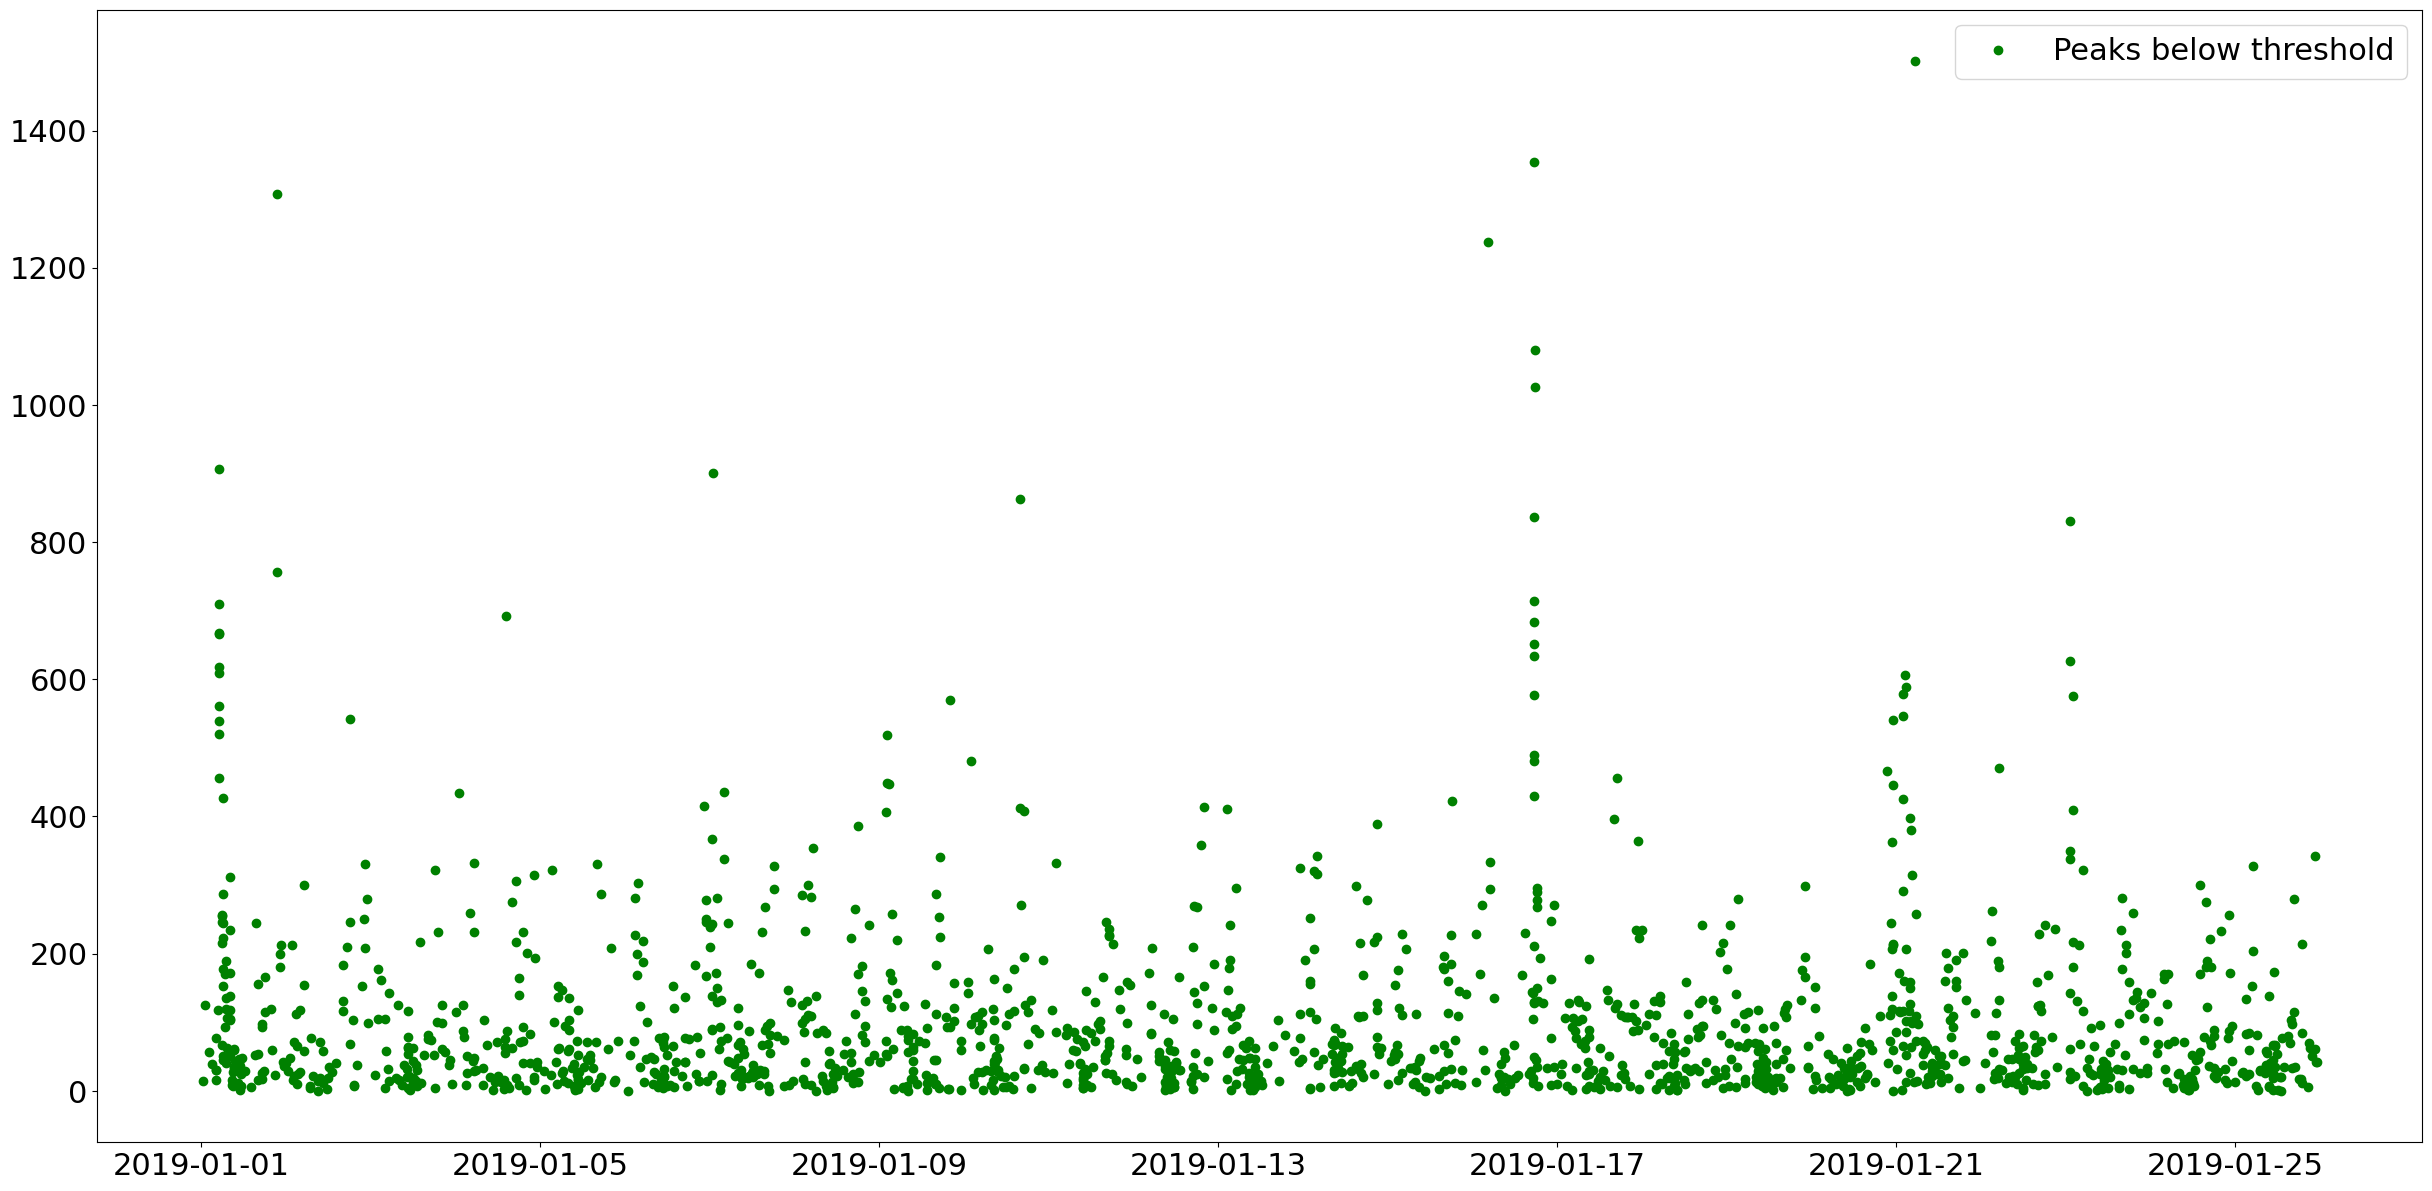

In [17]:
def plot_peakbelow_10():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)

    ax.plot(d.timestamps[701280:701280+10*period_10], peakbelow_10, marker='o', color='g', linestyle = 'None', label='Peaks below threshold')
    #ax.plot(df['peak_over'], marker='o', color='r', linestyle = 'None', label='Peaks over threshold')
    ax.legend()

plot_peakbelow_10()

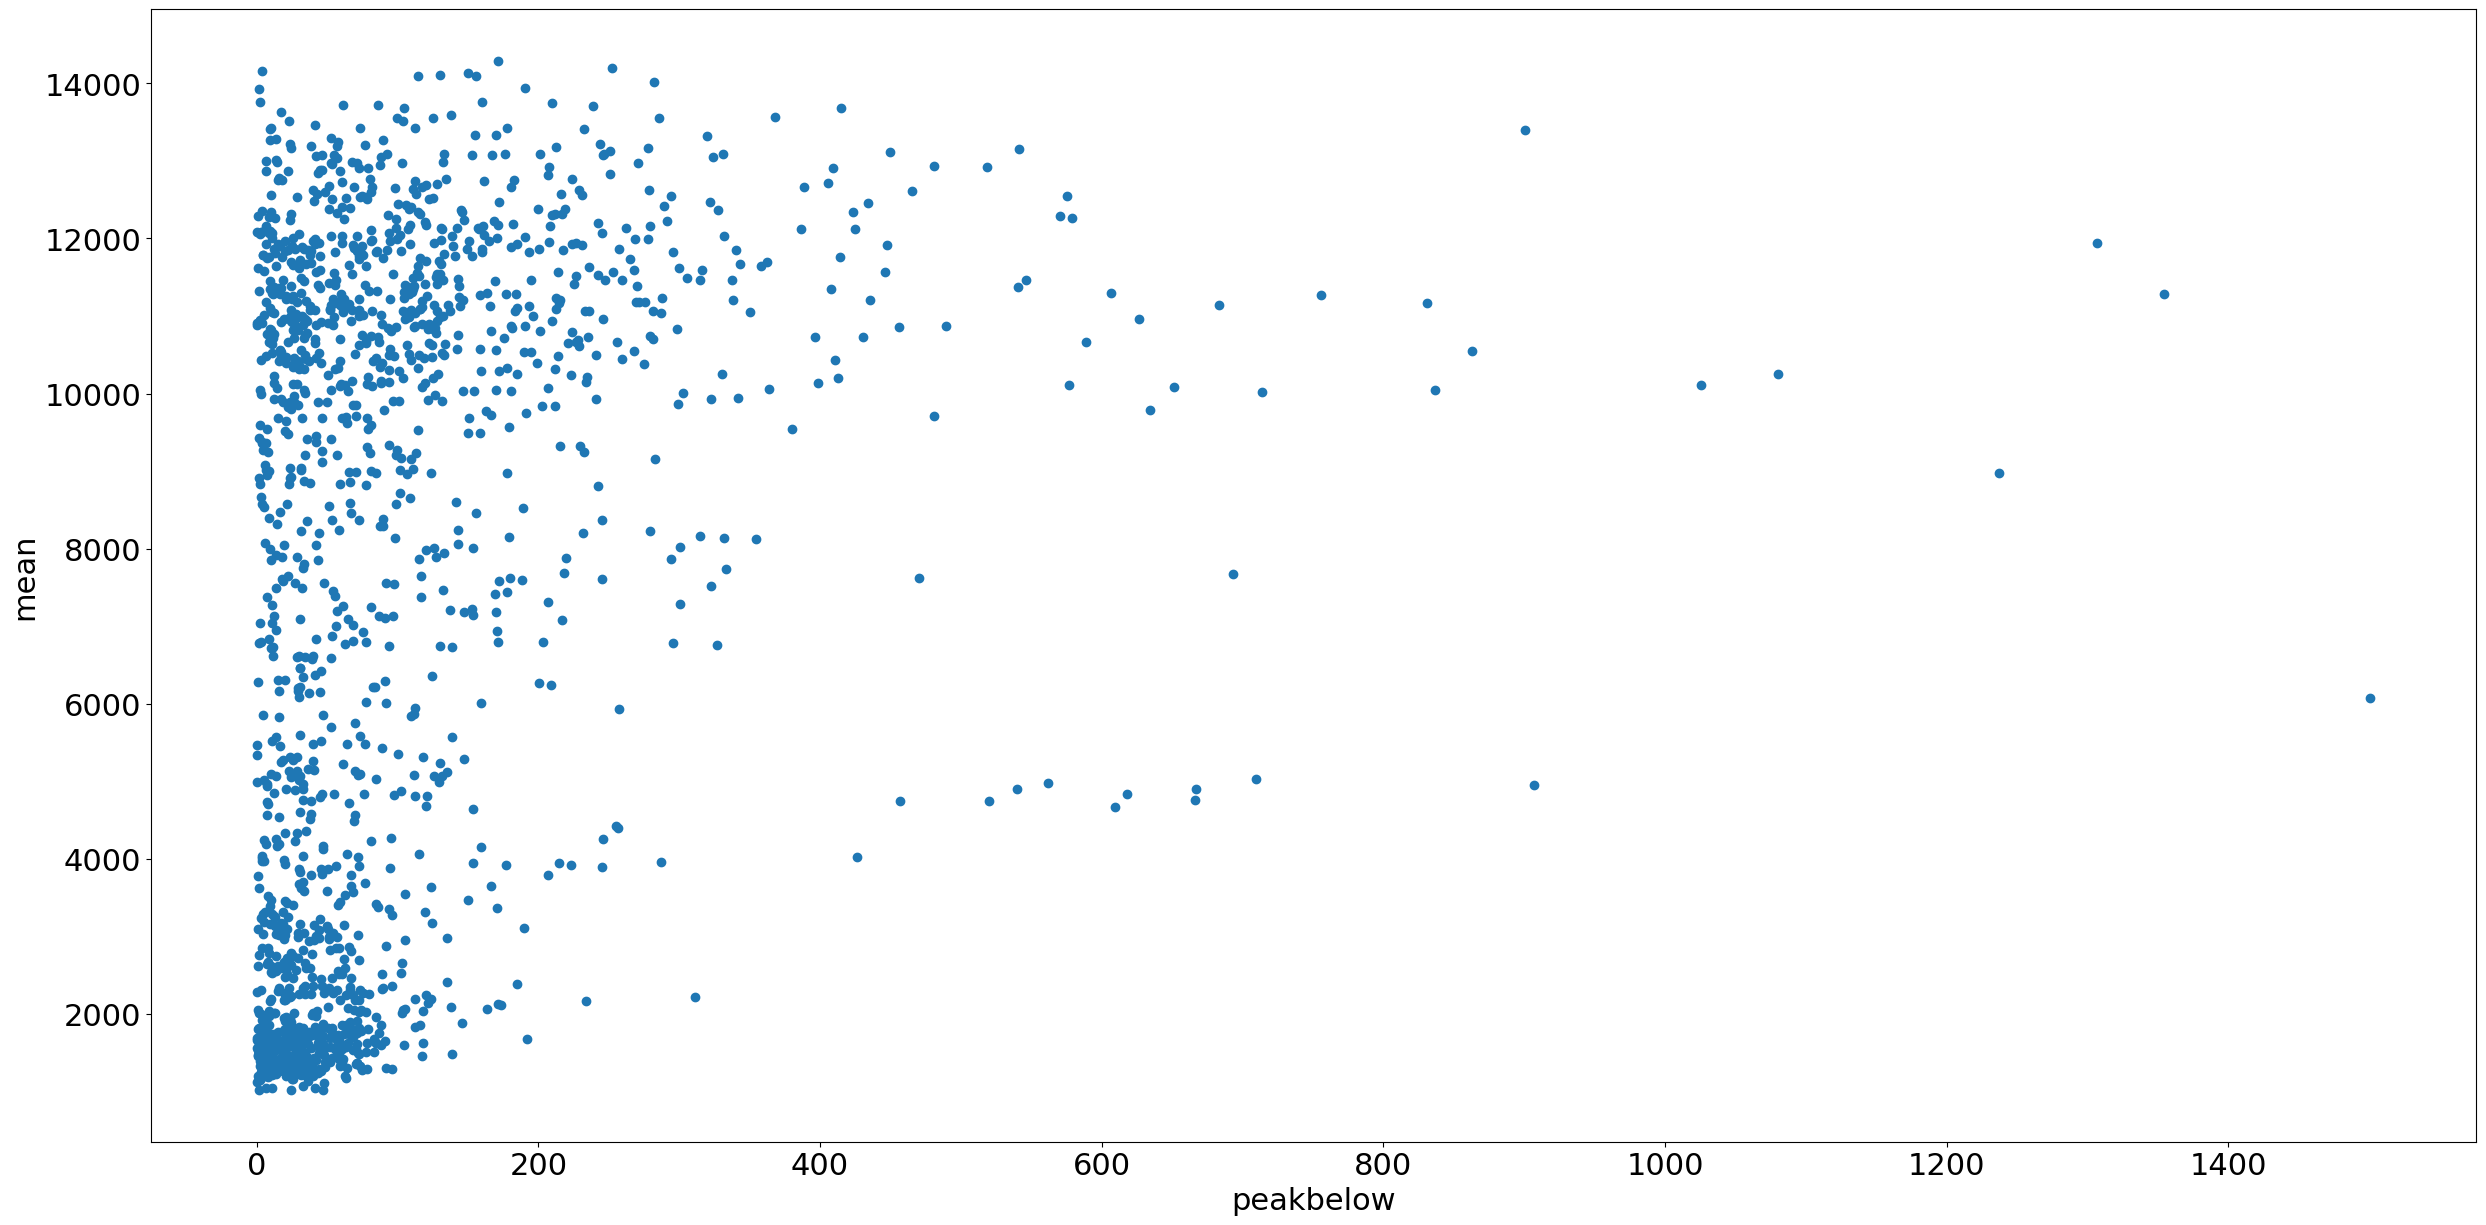

In [18]:
def plot_peakbelow_mean_10():
    plt.xlabel('peakbelow')
    plt.ylabel('mean')
    plt.scatter(peakbelow_10, mean_10)

plot_peakbelow_mean_10()

In [48]:
dataSeries_10 = pd.DataFrame({'observations': d.ts[701280:701280+10*period_10], 
                              'forecast_date': d.timestamps[701280:701280+10*period_10],
                              'mean': mean_10,
                              'peakbelow': peakbelow_10,
                              #'peakover': peakover_10,
                              #'threshold_over': threshold_over_10,
                              'threshold_below': threshold_below_10,
                              'mean': mean_10,
                              'score': score_10})
dataSeries_10['forecast_date'] = pd.to_datetime(dataSeries_10['forecast_date'])
dataSeries_10 = dataSeries_10.set_index('forecast_date', drop=True)
dataSeries_10['hour'] = dataSeries_10.index.hour
dataSeries_10['dayofweek'] = dataSeries_10.index.dayofweek
dataSeries_10['weekofyear'] = dataSeries_10.index.weekofyear
dataSeries_10['month'] = dataSeries_10.index.month

dataSeries_10

observations         mean  peakbelow  threshold_below  \
forecast_date                                                                
2019-01-01 00:00:00        8131.0  8224.454102        NaN      7615.645508   
2019-01-01 00:01:00        8305.0  8036.702637        NaN      7566.720215   
2019-01-01 00:02:00        8157.0  8378.990234        NaN      7863.094238   
2019-01-01 00:03:00        7982.0  8132.806641        NaN      7590.119141   
2019-01-01 00:04:00        8228.0  8638.282227        NaN      8183.107422   
...                           ...          ...        ...              ...   
2019-01-25 23:55:00        8685.0  8689.490234        NaN      8217.103516   
2019-01-25 23:56:00        8720.0  8746.724609        NaN      8192.191406   
2019-01-25 23:57:00        8658.0  8573.273438        NaN      7939.328125   
2019-01-25 23:58:00        8656.0  8884.088867        NaN      8330.210938   
2019-01-25 23:59:00        8569.0  8902.431641        NaN      8047.030762   

                        score  hour  dayofweek  weekofyear  month  
forecast_date                                                      
2019-01-01 00:00:00  0.063381     0          1           1      1  
2019-01-01 00:01:00  0.088896     0          1           1      1  
2019-01-01 00:02:00  0.036031     0          1           1      1  
2019-01-01 00:03:00  0.049096     0          1           1      1  
2019-01-01 00:04:00  0.005456     0          1           1      1  
...                       ...   ...        ...         ...    ...  
2019-01-25 23:55:00  0.053874    23          4           4      1  
2019-01-25 23:56:00  0.060529    23          4           4      1  
2019-01-25 23:57:00  0.083007    23          4           4      1  
2019-01-25 23:58:00  0.037637    23          4           4      1  
2019-01-25 23:59:00  0.060914    23          4           4      1  

[36000 rows x 9 columns]

In [52]:
def mk_ds_extreme_10(df):
    feat_dynamic_cat = np.vstack([df.hour.values, df.dayofweek.values, df.month.values])
    feat_dynamic_real = np.vstack([df['mean'].values]) # , df.stderr.values, df.dof.values 
    
    target = df.peakbelow.values
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'feat_dynamic_real': feat_dynamic_real,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': '2019-01-01 00:00:00',
        'observed_values': observed
                      }],
        freq='1min'
    )
    return ds

train_ds_extreme_10 = mk_ds_extreme_10(dataSeries_10.tail(-1000).dropna())
test_df_extreme_10 = dataSeries_10.tail(10000).dropna()
test_ds_extreme_10 = mk_ds_extreme_10(test_df_extreme_10)

dataSeries_10.tail(-1000).dropna()

observations          mean   peakbelow  threshold_below  \
forecast_date                                                                  
2019-01-01 17:04:00        9484.0  10081.127930   73.052734      9557.052734   
2019-01-01 17:05:00        9477.0   9950.974609   29.538086      9506.538086   
2019-01-01 17:06:00        9348.0   9967.059570   60.449219      9408.449219   
2019-01-01 17:07:00        9229.0   9853.950195   89.567383      9318.567383   
2019-01-01 17:09:00        9511.0  10240.669922   70.707031      9581.707031   
...                           ...           ...         ...              ...   
2019-01-25 21:59:00        9574.0  10250.902344    0.945312      9574.945312   
2019-01-25 22:36:00        8979.0   9643.596680   72.974609      9051.974609   
2019-01-25 22:38:00        9015.0   9900.543945  156.046875      9171.046875   
2019-01-25 23:04:00        8744.0   9354.089844   49.617188      8793.617188   
2019-01-25 23:44:00        8425.0   8953.627930   34.125000      8459.125000   

                        score  hour  dayofweek  weekofyear  month  
forecast_date                                                      
2019-01-01 17:04:00  0.007703    17          1           1      1  
2019-01-01 17:05:00  0.003117    17          1           1      1  
2019-01-01 17:06:00  0.006467    17          1           1      1  
2019-01-01 17:07:00  0.009705    17          1           1      1  
2019-01-01 17:09:00  0.007434    17          1           1      1  
...                       ...   ...        ...         ...    ...  
2019-01-25 21:59:00  0.000099    21          4           4      1  
2019-01-25 22:36:00  0.008127    22          4           4      1  
2019-01-25 22:38:00  0.017310    22          4           4      1  
2019-01-25 23:04:00  0.005674    23          4           4      1  
2019-01-25 23:44:00  0.004050    23          4           4      1  

[1501 rows x 9 columns]

# SimpleFeedForward Model on the Extreme Values

In [21]:
trainer_extreme_10 = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        )

In [22]:
prediction_length_10=20

model_extreme_10 = FeedForwardEstimator(
    freq='1min',
    prediction_length=prediction_length_10,
    num_hidden_dimensions=4*[20],
    context_length=180,
    trainer=trainer_extreme_10,
    mean_scaling=True,
    distr_output = PeakOverThresholdGeneralizedParetoOutput()
)

forecaster_extreme_10 = model_extreme_10.train_model(train_ds_extreme_10)
predictor_extreme_10 = forecaster_extreme_10.predictor

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:02<00:00, 39.04it/s, epoch=50/50, avg_epoch_loss=5.33]


In [23]:
pred_extreme_10 = predictor_extreme_10.predict(test_ds_extreme_10)
p_10 = next(iter(pred_extreme_10))
p_10.distribution

gluonts.distribution.transformed_distribution.TransformedDistribution(base_distribution=__main__.PeakOverThresholdGeneralizedPareto(F=None, concentration=mxnet.nd.array([0.0002873537305276841, 0.00035231138463132083, 0.00012205087841721252, 0.0003071280079893768, 0.0006747310981154442, 0.00011322966747684404, 0.00011047031875932589, 0.00010783942707348615, 0.00017458247020840645, 0.00011345274106133729, 0.00026231922674924135, 0.00027659969055093825, 0.024250375106930733, 0.012215192429721355, 0.0030486166942864656, 0.0006169849657453597, 0.00174222351051867, 0.026020139455795288, 0.009543093852698803, 0.00271310331299901], dtype=numpy.float32), scale=mxnet.nd.array([0.9460145831108093, 0.9471548795700073, 1.3614839315414429, 1.2760852575302124, 1.548043131828308, 0.8648512959480286, 0.42193666100502014, 0.6618199348449707, 0.5076563358306885, 0.8321844339370728, 0.5731267929077148, 0.41451719403266907, 0.7726794481277466, 0.9510383605957031, 0.7282177805900574, 0.8694705367088318, 0.4

In [24]:
tss_extreme_10 = list(test_ds_extreme_10)
target_extreme_10 = tss_extreme_10[0]['target'][-prediction_length_10:]#mk_ds
threshold_extreme_10 = test_df_extreme_10.threshold_below.tail(prediction_length_10).values
peak_ratio_extreme_10 = dataSeries_10.peakbelow.notna().sum() / dataSeries_10.peakbelow.size
peak_ratio_extreme_10

0.04425

In [25]:
def plot_prob_forecasts_10(target, threshold, samples, test_df, prediction_length, alarm_level, peak_ratio, transforms):
    percentiles = [50, 75, 90, 95, 99]
    legend = ["observations", "threshold", "cutoff"] + [f"p{k} of the Generalized Pareto" for k in percentiles]

    idx = test_df.tail(prediction_length).index
    
    fig, ax = plt.subplots(prediction_length, 1, figsize=(10, 20 * prediction_length))
    
    # Compute the absolute target
    adjusted_target = threshold - target
    
    # Compute percentiles of the predictive distribution
    pct = np.percentile(samples, percentiles, axis=0)

    # Compute alarm cutoff 
    cutoff = p_10.distribution.base_distribution.base_distribution_quantile(
        level=alarm_level,
        threshold=mx.nd.array(threshold),
        peak_ratio=peak_ratio,
        transforms=transforms,
        below=True
    ).asnumpy()
    
    for sp in range(prediction_length):
        ax[sp].set_title(f"Date: {idx[sp]}\n Peak below: {target[sp]} \n Alarm quantile: {alarm_level}")

        # plot the time series
        pd.Series(adjusted_target[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20 )  
        
        # plot the time series
        pd.Series(threshold[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20, color='g')

        # plot the cut-off
        pd.Series(cutoff[sp]).plot(ax=ax[sp], linestyle = 'None', marker = '^', markersize=20, color='r')
        
        # plot the percentiles of the GPD
        for i in range(len(percentiles)):
            adjusted_percentile = threshold - pct[i,:]
            pd.Series(data=adjusted_percentile[sp]).plot(
                    ax=ax[sp], marker='X', markersize=10, color=cm.hot(i/len(percentiles)), linestyle = 'None')


        ax[sp].grid(which="both")

    fig.legend(legend, loc="best")
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


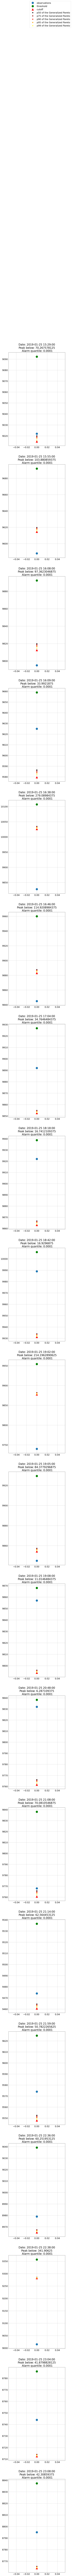

In [26]:
samples_extreme_10 = p_10.distribution.sample(1000).asnumpy()
alarm_level = 1e-4

plot_prob_forecasts_10(target_extreme_10,
                       threshold_extreme_10,
                       samples_extreme_10,
                       test_df_extreme_10,
                       prediction_length_10,
                       alarm_level,
                       peak_ratio_extreme_10,
                       p_10.distribution.transforms)

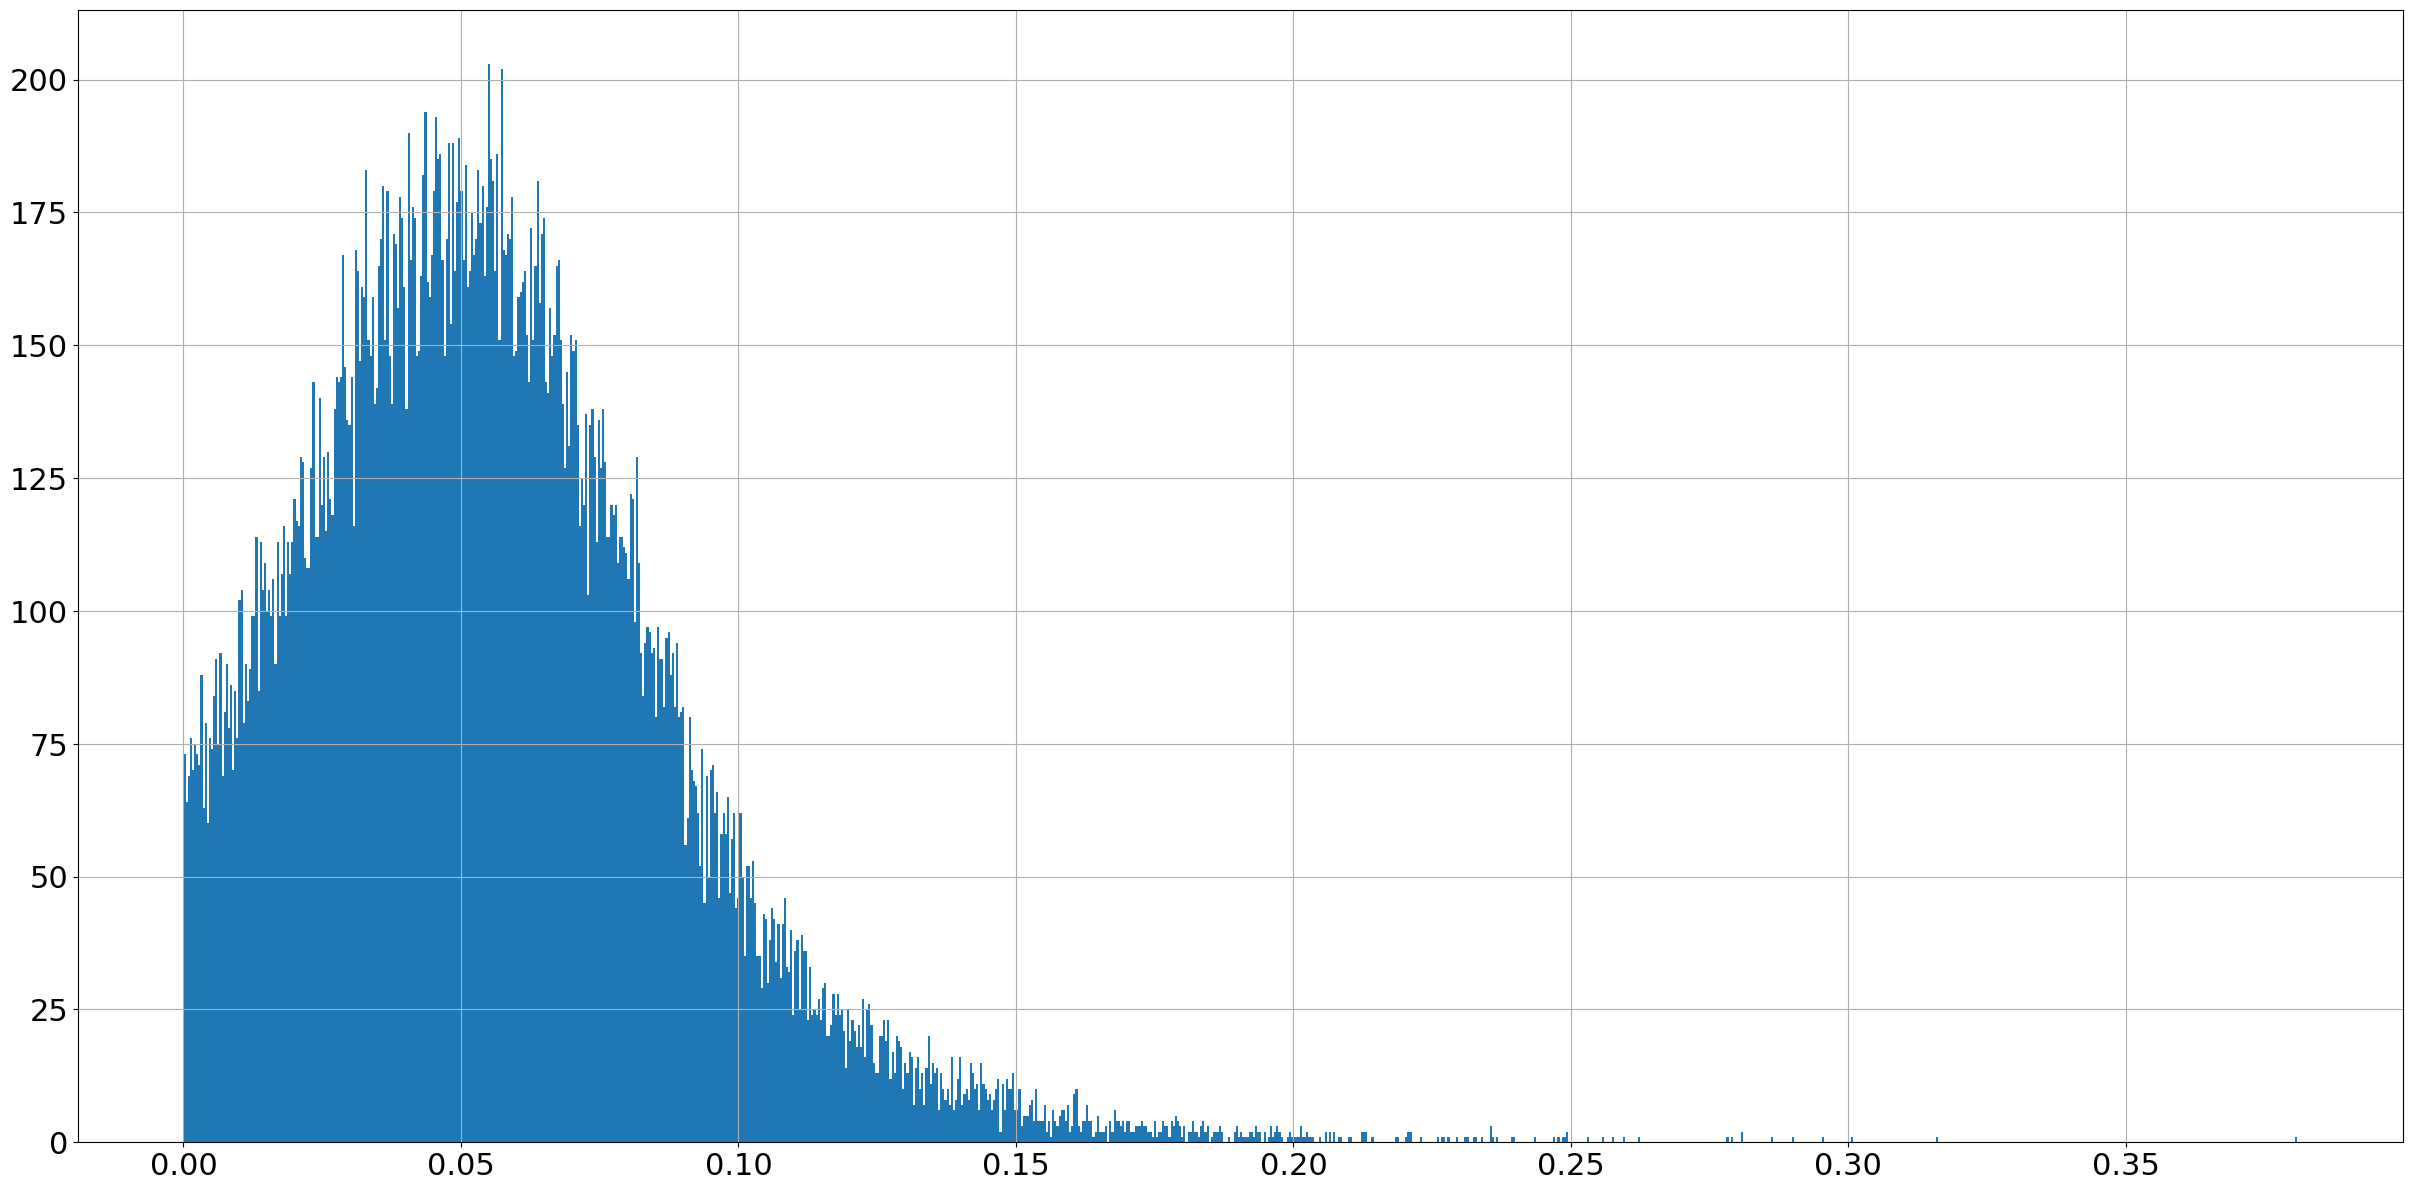

In [55]:
#dataSeries_10.observations[dataSeries_10.observations<2000].hist(bins=1000)
dataSeries_10['score'][dataSeries_10['score']<0.5].hist(bins=1000)

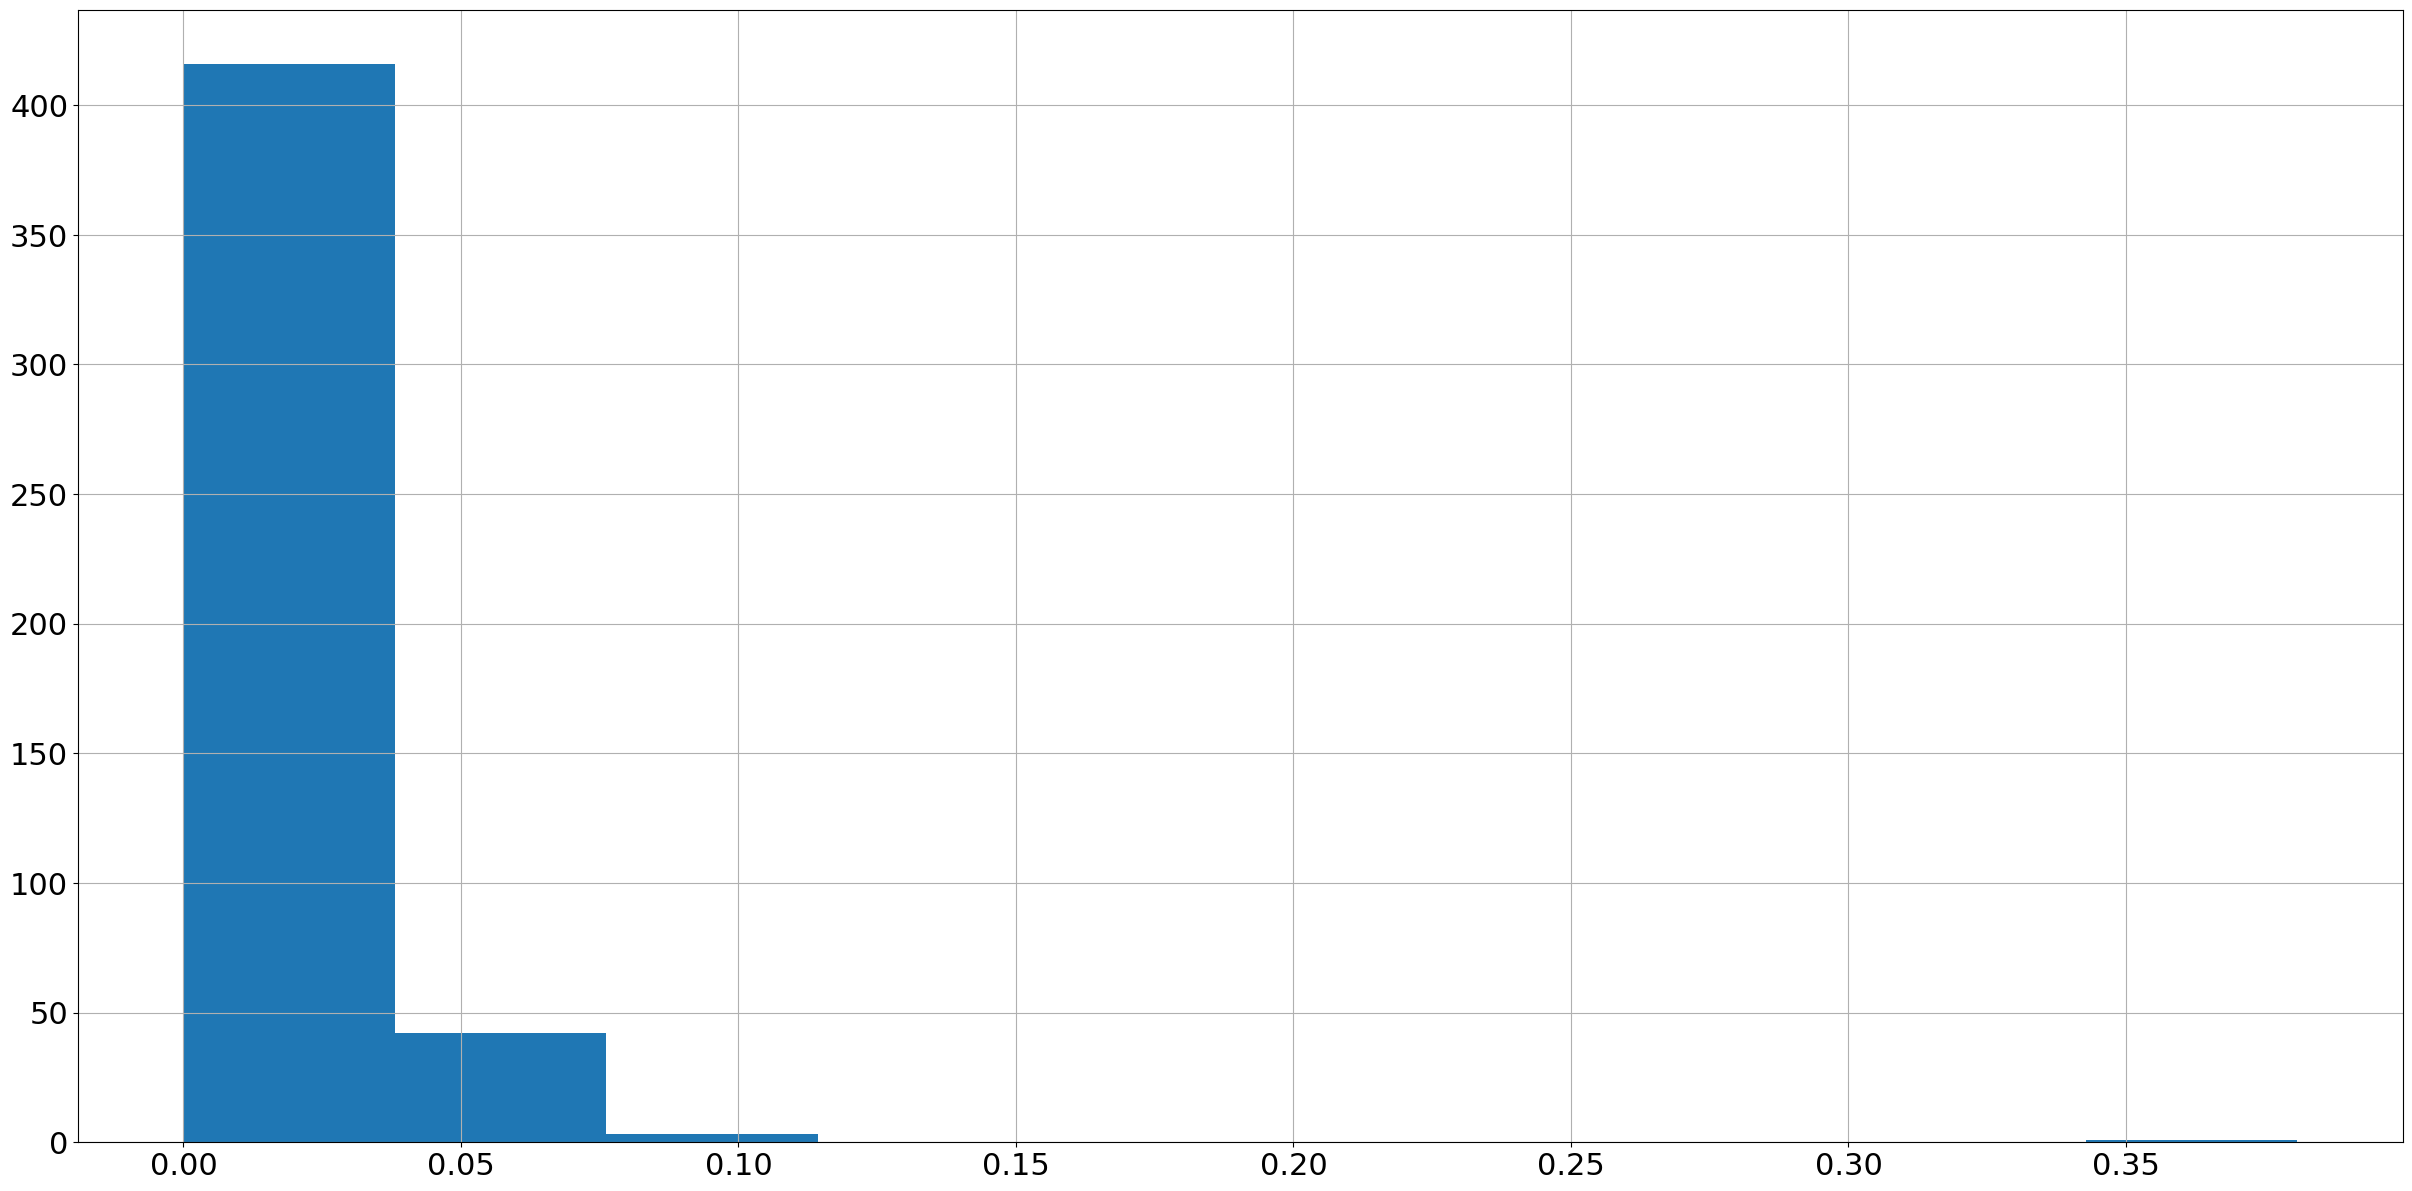

In [53]:
test_df_extreme_10.score.hist(bins=10)